  ## Введение


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


В нашем распоряжении четыре датасета:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

В каждом содержится поле customerID - уникальный идентификатор клиента.

Описание полей данных:
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип договора: ежемесячный, годовой и т.д,
- PaperlessBilling – факт выставления счёта на электронную почту,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги,
- Dependents – наличие иждивенцев,
- Senior Citizen – наличие пенсионного статуса по возрасту,
- Partner – наличие супруга(и),
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Для оценки качества модели будет использована метрика ROC-AUC, в качестве дополнительной - метрика f1. Также при выборе модели будет учитываться время обучения.

Цель проекта: спрогнозировать факт ухода клиента из компании, решается задача классификации.


###  План

1. Введение
- план и технический раздел: импорты бибилиотек, функции

2. Чтение и краткий обзор данных.
- Изучение распределений значений столбцов. Базовая предобработка данных: реобразования типов, по необходимости - заполнение пропусков.

3. Объединение датасетов  
- Формирование единого датасета с признаками и целевого признака. Создание синтетических признаков и явного целевого признака. Удаление ненужных столбцов.

4. Исследовательский анализ данных.
- Поиск зависимостей между признаками и целевым признаком. Изучение корреляций между признаками. Проверка на мультиколлинеарность.

5. Подготовка данных к построению моделей.
- Выделение целевого признака. Разбиение данных на выборки. Кодирование, борьба с дисбалансом, масштабирование количественных признаков

6. Построение и оптимизация моделей.
- Подбор гиперпараметров, выбор наиболее оптимальной модели через призму максимизации метрики.

7. Проверка модели. Сравнение с константной.

8. Тестирование полученной модели.
- анализ важности признаков, оптимизация выбранной модели с учётом полученных результатов.

9. Вычисление итогового значения метрики для выбранной модели на тестовой выборке.

10. Заключение

  ### Технический раздел

импорты бибилиотек, функции, использующиеся в теле кода и тд

In [1]:
# устанавливаем библиотеку phik для корреляции между качественными признаками
!pip install phik -q
# обновление версии matplotlib - для возможности пользоваться удобным редактированием границ и автоподстройкой графиков
!pip install --upgrade matplotlib -q
!pip install scikit-learn==1.1.3 -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00


In [2]:
#необходимые импорты
import warnings

import datetime
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import phik
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.compose import (
    make_column_transformer,
    make_column_selector
)
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from lightgbm import LGBMClassifier
from sklearn.linear_model import (
    LogisticRegression,
    Ridge,
    SGDClassifier
)
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)

from sklearn.feature_selection import (
    SelectKBest,
    chi2,
    mutual_info_classif,
    f_classif
)


warnings.filterwarnings("ignore")

RANDOM_STATE = 300623
DATE_DOWNLOAD = datetime(2020, 2, 1)

In [3]:
# функция для обзора датасета - количество строк и столбцов,
def ds_describe(data):
    print(f'Размер датасета = {data.shape}')
    print('Количество значений и тип данных в столбцах:')
    print(data.info())
    print('Превью датасета:')
    display(data.head())


In [4]:
# функция для отрисовки распределений значений столбцов
def column_draw(column, xlabel, ylabel, title=None):
    column.hist()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title);

In [5]:
# функия для строки - количество сервисом, подключённых у пользователя
def num_of_services(row):
    count=0
    for col in data.columns:
        if row[col]=='Yes' and str(col)!='PaperlessBilling':
            count+=1
    return count

In [6]:
#функция для добавления целевого признака: если даты окончания договора нет - клиент активен
def add_target(row):
    if row['EndDate']=='No':
        return 0
    else:
        return 1

In [7]:
# функция строки: добавление признака длительности контракта
def period(row):
  return (row['EndDate'] - row['BeginDate']).days

In [8]:
#функция для отображения распределения признака в разрезе значения целевого признака
def column_target_draw(column):
    plt.hist([data[data['not_active']==0][column], data[data['not_active']==1][column]], label = ['active clients', 'disactive clients'])
    plt.xlabel('meaning')
    plt.ylabel('quantity')
    plt.legend()
    plt.title(data[column].name)



In [9]:
# функция, генерирующая пайплайн обучения модели с подбором гиперпараметров и кросс-валидацией
# на выходе отдаёт метрику ROC-AUC, гиперпараметры наиболее оптимальной конфигурации и время обучения модели
def model_pipeline(transformer, model, x, y, params={}):
    pipeline = make_pipeline(transformer, model)


    gs_pl = GridSearchCV(
        pipeline,
        param_grid=params,
        scoring='roc_auc',
        n_jobs=-1,
        refit=True
    )

    gs_pl.fit(x, y)

    gs_best_score = gs_pl.best_score_
    gs_best_params = gs_pl.best_params_
    gs_best_time = gs_pl.refit_time_
    print(f'Для модели {model} метрика ROC-AUC ={gs_best_score:.3}')
    print(f'время обучения ={gs_best_time:.3}, параметры модели:{gs_best_params}')
    return gs_best_score, gs_best_params, gs_best_time

## Чтение и обзор данных

In [10]:
# считываем все датасеты
#уникальный ID будет индексом - для удобства дальнейшего объединения таблиц
try:
    contract = pd.read_csv('contract_new.csv', index_col='customerID')
    internet = pd.read_csv('internet_new.csv', index_col='customerID')
    users = pd.read_csv('personal_new.csv', index_col='customerID')
    phone = pd.read_csv('phone_new.csv', index_col='customerID')
except:
    contract = pd.read_csv('/datasets/contract_new.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
    users = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

Дальше сделаем так: детально посмотрим сначала на общую информацию о датасете: количество столбцов и строк, тип данных, наличие пропусков. Затем изучим распределения значений в каждом столбце.

### Персональные данные клиента

In [11]:
ds_describe(users)

Размер датасета = (7043, 4)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None
Превью датасета:


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


Семь тысяч пользователей, четыре характеристики каждого пользователя. Пропуски отсутствуют.

Далее посмотрим более внимательно на каждую колонку. Начнём с гистограмм распределения значений в каждом столбце

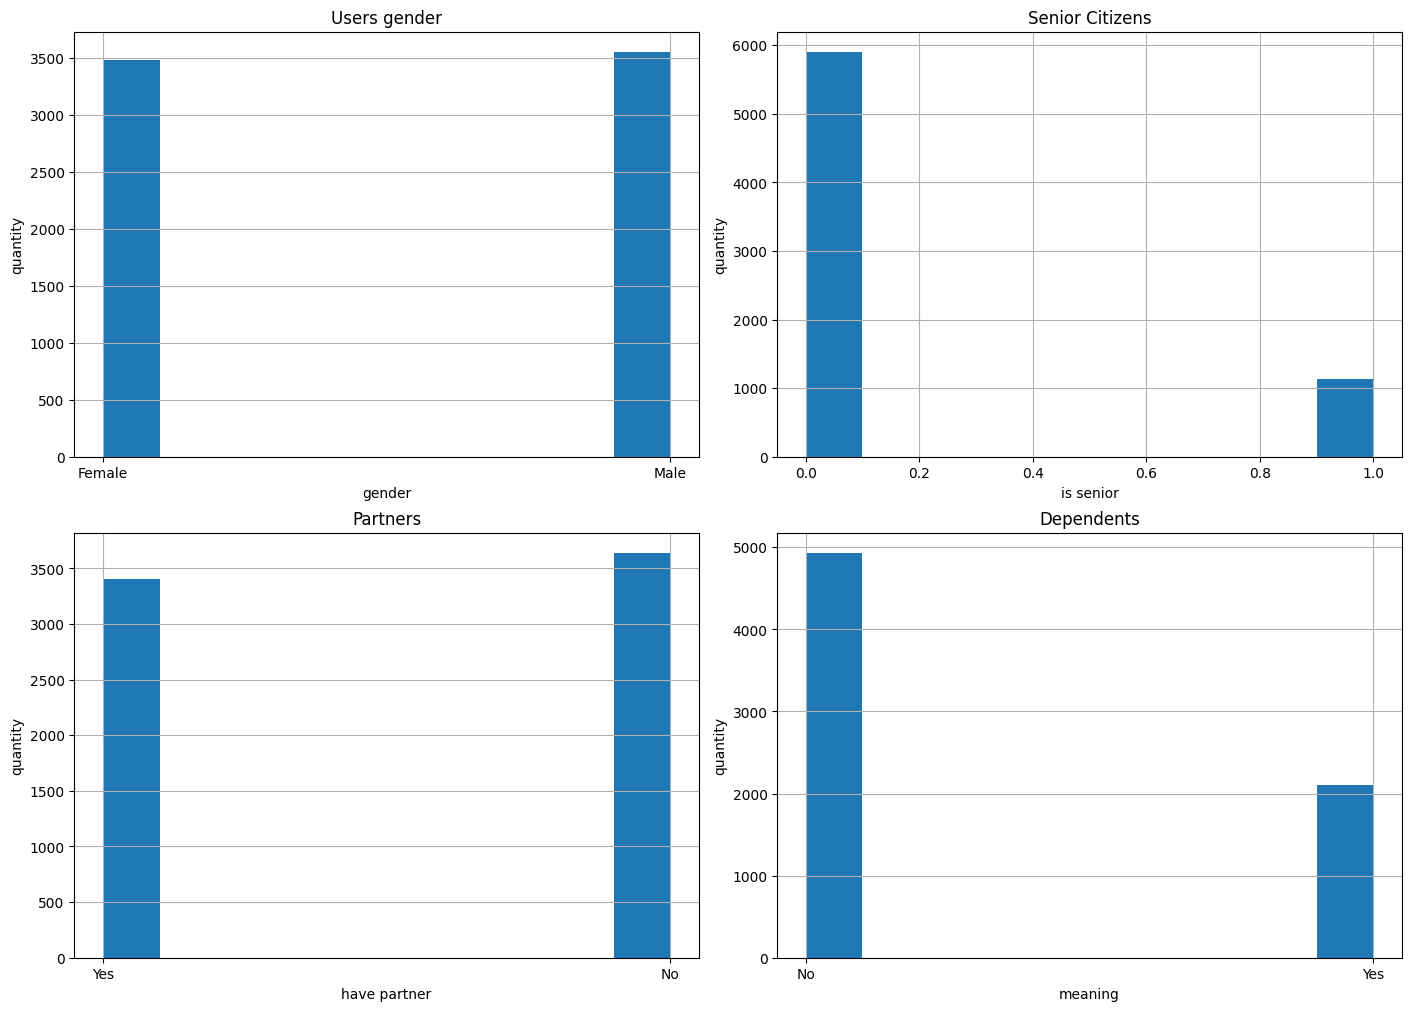

In [12]:
plt.figure(figsize=(14, 10), layout='constrained')
plt.subplot(2, 2, 1)
column_draw(users['gender'], 'gender', 'quantity', 'Users gender')
plt.subplot(2, 2, 2)
column_draw(users['SeniorCitizen'], 'is senior', 'quantity', 'Senior Citizens')
plt.subplot(2, 2, 3)
column_draw(users['Partner'], 'have partner', 'quantity', 'Partners')
plt.subplot(2, 2, 4)
column_draw(users['Dependents'], 'meaning', 'quantity', 'Dependents')

Все признаки в этом датасете - качественные. Видны следующие особенности:
- количество женщин и мужчин в выборке примерно одинаковое
- примерно у 15 процентов выборки есть пенсионный возраст
- примерно половина клиентов имеют партнёров (не имеющих - чуть больше)
- две трети клиентов имеют иждивенцев

### Информация о договорах

Начинаем с обзора датасета:

In [13]:
ds_describe(contract)

Размер датасета = (7043, 7)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None
Превью датасета:


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Признаки с датами пока пропустим и посмотрим их чуть позже. Изучим распределения остальных признаков:

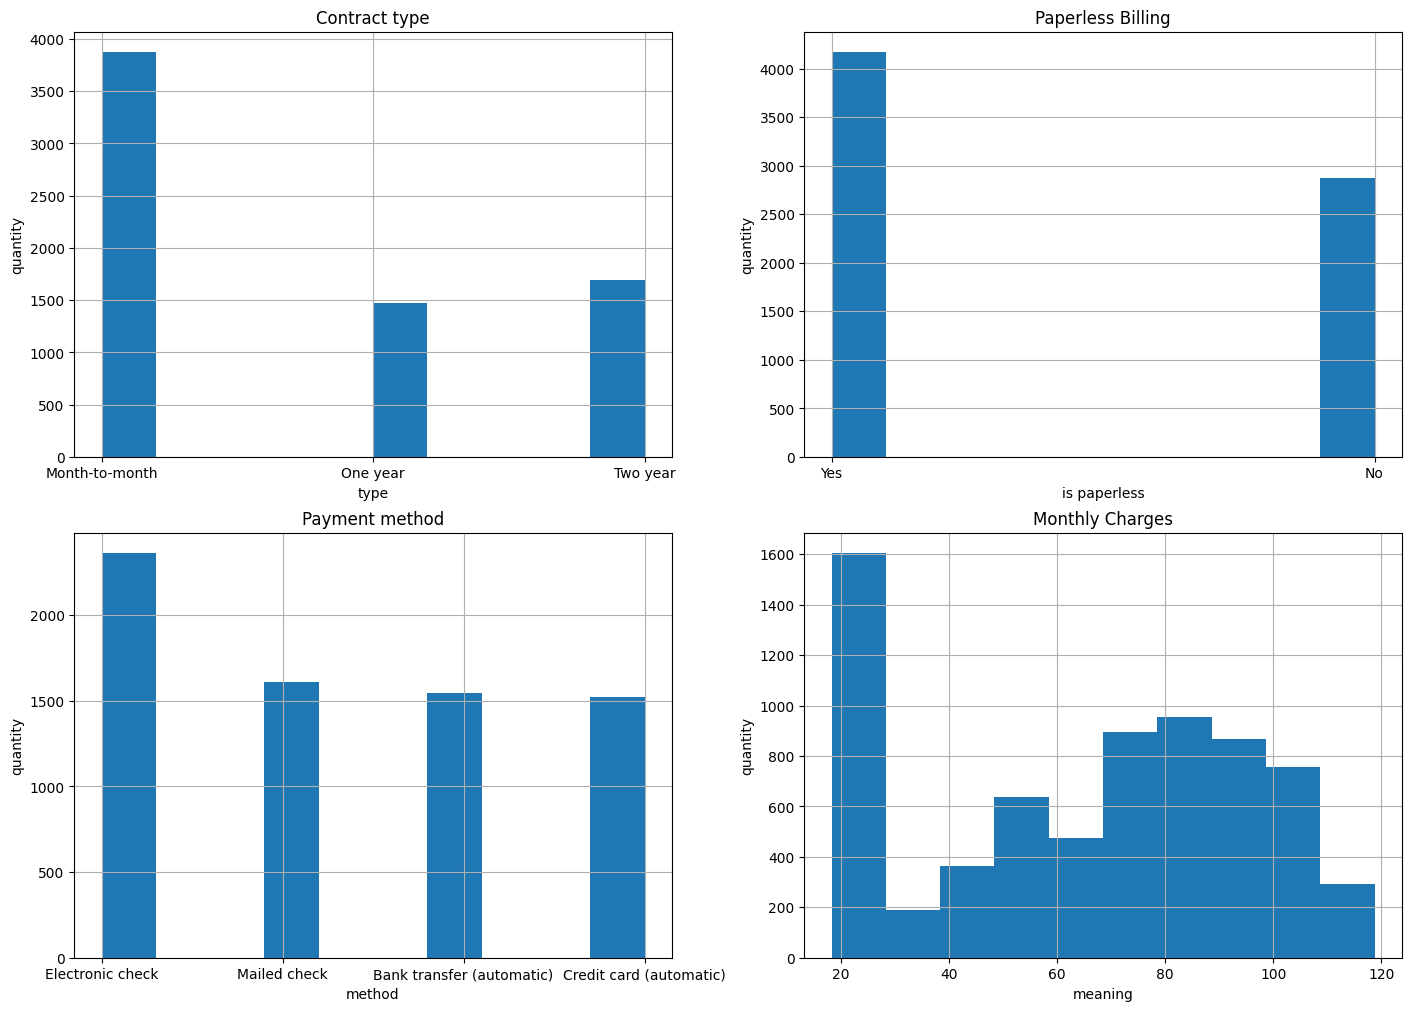

In [14]:
plt.figure(figsize=(14, 10), layout="constrained")
plt.subplot(2, 2, 1)
column_draw(contract['Type'], 'type', 'quantity', 'Contract type')
plt.subplot(2, 2, 2)
column_draw(contract['PaperlessBilling'], 'is paperless', 'quantity', 'Paperless Billing')
plt.subplot(2, 2, 3)
column_draw(contract['PaymentMethod'], 'method', 'quantity', 'Payment method')
plt.subplot(2, 2, 4)
column_draw(contract['MonthlyCharges'], 'meaning', 'quantity', 'Monthly Charges')


Первые три признака - качественные, ежемесячный платёж - количественный.
- более половины клиентов предпочитают помесячные платежи. Оставшаяся часть распределена примерно поровну между годовыми и двухлетними контрактами, но последних немного больше
- больше половины клиентов предпочитают оплату без бумажных чеков
- среди способов оплаты лидирует электронный чек. Чек по почте, автоматический банковский перевод и автосписание с карты примерно одинаковы по количеству пользователей.
- распределение по месячным расходам имеет два пика. Первый, явно выраженный - в районе двадцати. Вероятно, это соответсвует ежемесячному платежу по минимальному тарифу. Если отбросить этот пик - остальная часть распределения похожа на нормальное с пиком в районе 80-ти.

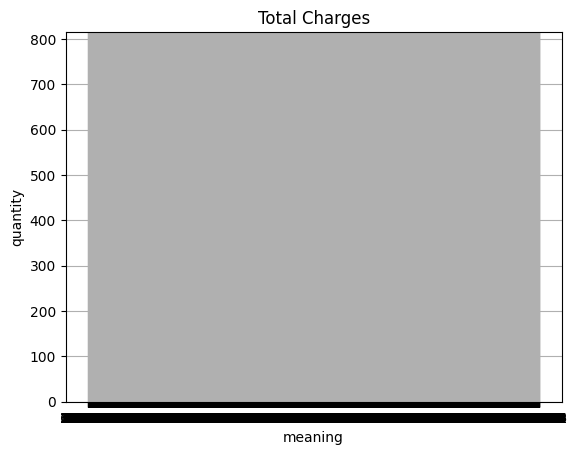

In [15]:
#смотрим на распределение потраченных денег на услуги
column_draw(contract['TotalCharges'], 'meaning', 'quantity', 'Total Charges')

Кажется, в этой колонке что-то интересное - неудивительно с учётом типа Object, это явный признак наличия проблем :) Посмотрим более детально на неё.

In [16]:
sum(contract['TotalCharges'].str.isdigit())

0

То есть в этом столбце сейчас вообще нет чисел

In [17]:
contract['TotalCharges'].head()

customerID
7590-VHVEG      31.04
5575-GNVDE    2071.84
3668-QPYBK     226.17
7795-CFOCW     1960.6
9237-HQITU      353.5
Name: TotalCharges, dtype: object

Но визуально значения числовые. Смотрим на тип данных на примере одного значения:

In [18]:
type(contract.loc['7590-VHVEG','TotalCharges'])

str

Вот оно - то есть в этом столбце у нас числовые значения, записанные в виде строки. Переведём сразу в численный формат - это не приниципиальное изменение датасета и даст возможность изучить распределение:

In [19]:
#некорректные значения (например, пустые строки) заполняем NaN
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [20]:
contract[contract['TotalCharges'].isna()].head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN


Знаем по ТЗ, что база выгружена в феврале 2020-ого года - в дате начала контакта как раз февраль 2020-ого. Вероятно, это новые клиенты. Проверяем:

In [21]:
contract[contract['TotalCharges'].isna()]['BeginDate'].value_counts()

2020-02-01    11
Name: BeginDate, dtype: int64

Действительно, это 11 новых клиентов, других клиентов с пропусками в этом столбце нет - значит, они ещё не успели внести первый платёж, или он ещё не отображалс в базе на момент выгрузки.

In [22]:
# все NaN заполняем нулями
contract['TotalCharges'] = contract['TotalCharges'] .fillna(0)

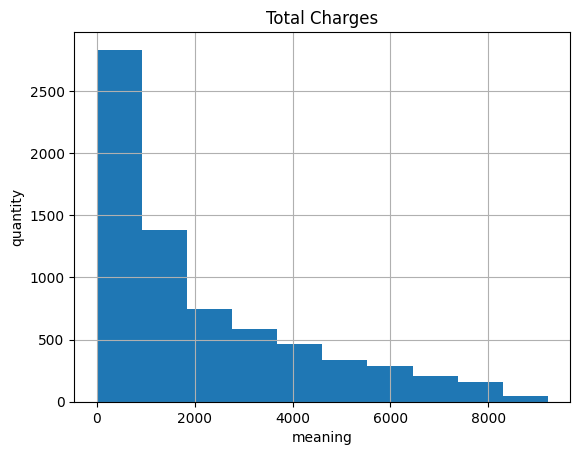

In [23]:
# теперь можем, наконец, посмотреть на распределение:
column_draw(contract['TotalCharges'], 'meaning', 'quantity', 'Total Charges')

Распределение имеет вид распределения Пуассона с пиком в районе тысячи. Большинство клиентов сосредоточено в интервале от 0 до 2 тысяч.

Интересно посмотреть на дату начала контакта. Однако, распределения по дням неинтересны - ограничимся годом.

In [24]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

In [25]:
#  проверяем изменение типа данных
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 698.2+ KB


In [26]:
#Новый столбец - с годом начала контракта
contract['BeginYear'] = contract['BeginDate'].dt.year

Text(0.5, 1.0, 'Begin contracts year')

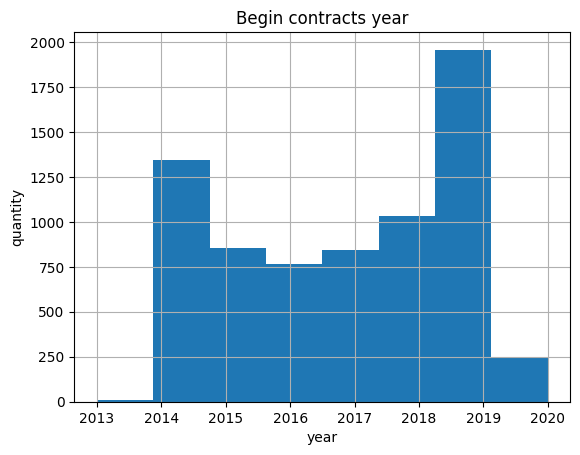

In [27]:
contract['BeginYear'].hist(bins=8)
plt.xlabel('year')
plt.ylabel('quantity')
plt.title('Begin contracts year')

Пик притока клиентов пришёлся на 2019 год - почти в два раза по сравнению с 2018-ым - возможно, помимо общего тренда роста рынка, повлияла удачная рекламная кампания. Спад в 2015ом году после 2014ого может быть обусловлен валютным кризисом. Клиентов с 2013 года очень мало - либо вопрос репрезентативности выборки, либо компания открылась в 2013ом, и клиентов было совсем немного. Между 15ым и 18ым годами количество заключённых контрактов росло приблизительно равномерно. В 2020ом году договоров мало - вероятно, данные за 2022ый год неполные, и база была выгружена в первой трети года.

Теперь посмотрим на столбец EndDate - дату окончания контракта. На самом деле для нас эта колонка - как раз целевой признак: если дата есть - значит, клиент ушёл. если значение = 'No' - это активный клиент.

In [28]:
print('Количество незаконченных контактов =', \
    len(contract[contract['EndDate']=='No']), 'из', len(contract) )

Количество незаконченных контактов = 5942 из 7043


В датасете всего 15 процентов клиентов с завершёнными контактами, что идеологически правдоподобно: чем больше активных клиентов - тем больше прибыль компании. С точки зрения дальнейшего обучения модели - присутсвует явный существенный дисбаланс классов.

###  Интернет-услуги

In [29]:
ds_describe(internet)

Размер датасета = (5517, 7)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None
Превью датасета:


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


 Семь столбцов, пропусков нет, признаки - качественные.

 Далее посмотрим каждый признак отдельно:

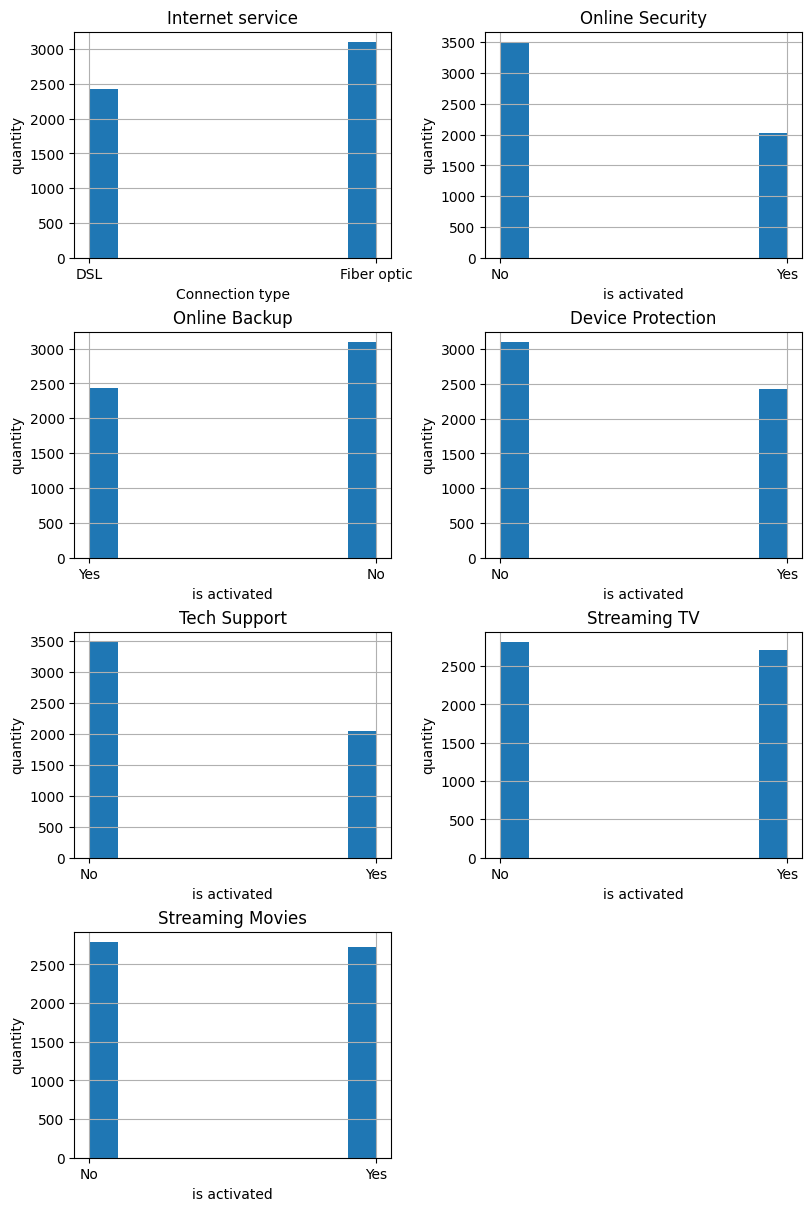

In [30]:
plt.figure(figsize=(8, 12), layout="constrained")
plt.subplot(4, 2, 1)

column_draw(internet['InternetService'], 'Connection type', 'quantity', 'Internet service')
plt.subplot(4, 2, 2)
column_draw(internet['OnlineSecurity'], 'is activated', 'quantity', 'Online Security')
plt.subplot(4, 2, 3)
column_draw(internet['OnlineBackup'], 'is activated', 'quantity', 'Online Backup')
plt.subplot(4, 2, 4)
column_draw(internet['DeviceProtection'], 'is activated', 'quantity', 'Device Protection')
plt.subplot(4, 2, 5)
column_draw(internet['TechSupport'], 'is activated', 'quantity', 'Tech Support')
plt.subplot(4, 2, 6)
column_draw(internet['StreamingTV'], 'is activated', 'quantity', 'Streaming TV')
plt.subplot(4, 2, 7)
column_draw(internet['StreamingMovies'], 'is activated', 'quantity', 'Streaming Movies')

Все признаки - качественные. Более детально по каждому признаку:
- типов подключений примерно поровну, но подключений через оптоволоконный кабель чуть больше, чем через телефонную линию DSL
- блокировка небезопасных сайтов: пользователей с включённой услугой - примерно треть
- подключение облачного хранилища: количество пользователей примерно равно, но тех, у которых данная услуга не подключена, чуть больше
- подключение антивируса: количество пользователей в этих категориях примерно равно, но тех, в кото подключена данная услуга, меньше
- техподдержкой пользуется чуть больше трети пользователей
- стриминговое телевидение и каталог фильмов подключены примерно у половины пользователей.

Интересно было бы посмотреть, например, корреляцию между стриминговым телевидением и каталогом фильмов, но это будет сделано далее в разделе EDA.

### Услуги телефонии

In [31]:
ds_describe(phone)

Размер датасета = (6361, 1)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None
Превью датасета:


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


Пропусков нет.

Здесь единственный столбец - MultipleLines – наличие возможности ведения параллельных линий во время звонка.

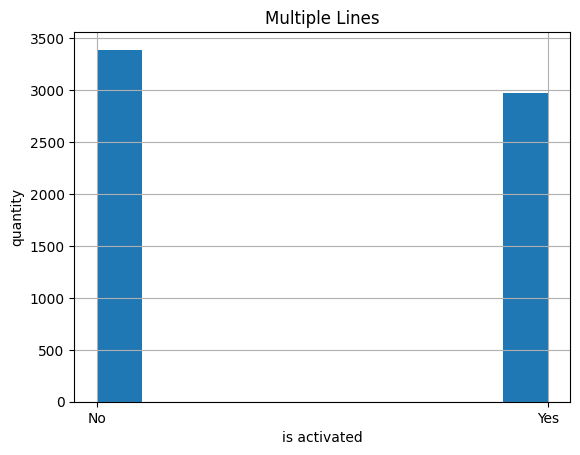

In [32]:
column_draw(phone['MultipleLines'], 'is activated', 'quantity', 'Multiple Lines')

Качественный признак.

Отрицательных значений чуть больше положительных, но в целом количество соизмеримо.

Вывод по разделу:

Проведено чтение и первичный обзор данных в датасетах. В нашем распоряжении база из семи тысяч клиентов, пользующихся телефонией и/или интернетом. Явных пропусков нет. Большинство признаков - качественные кроме двух: ежемесячного платежа и общей потраченной суммы.
Что касается качественных признаков, данные в выборке распределены примерно равномерно. Что касается количественных признаков, распределение потраченной суммы стремится к Пуассоновскому, а у ежемесячного платежа два пика - в районе 20 (вероятно, соответсвующее минимальному ежемесячному платежу) и в районе 80-ти (возможно, это ежемесячный платёж популярного расширенного тарифа).

Распределение целевого признака изучено косвенно из даты окончания контракта. В выборке присутсвует дисбаланс: всего 15 процентов клиентов базы закончили сотрудничество с провайдером.

## Объединение датасетов

Для дальнейшего обучения моделей собираем все данные о клиентах в единую таблицу с признаками. Слияние выполняем по уникальному идентификатору пользователя.

In [33]:
data = contract.merge(internet, how='left', left_index=True, right_index=True)
for ds in [phone, users]:
    data = data.merge(ds, how='left', left_index=True, right_index=True)

Проверяем, что получилось: ожидаем увидеть датасет из семи тысяч строк с признаками из всех таблиц, то есть должно получится 20 столбцов - с учётом уже созданного признака с годом.

In [34]:
ds_describe(data)

Размер датасета = (7043, 20)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   BeginYear         7043 non-null   int64         
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginYear,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,2020,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,2017,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,2019,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,2016,DSL,Yes,No,Yes,Yes,No,No,NaN,Male,0,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,2019,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No


### Заполнение пропусков

Причина наличия пропусков в итоговой таблице -не все клиенты пользуются и услугами телефонии, и интернетом. Пропуски как раз в столбцах, относящихся к этим секторам. Поэтому поступим так: если в этих столбцах пропуск - значит, услуга не подключена. Для того, чтобы в дальнейшем можно было легко воспользоваться кодировщиком - заполним пропуски значением "No", то есть услуга не подключена.

In [35]:
#список колонок на заполнение
column_to_fill = [col for col in data.columns if sum(data[col].isna())>0]

In [36]:
for column in column_to_fill:
    data[column] = data[column].fillna('No')

In [37]:
#проверяем
ds_describe(data)

Размер датасета = (7043, 20)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   BeginYear         7043 non-null   int64         
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginYear,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,2020,DSL,No,Yes,No,No,No,No,No,Female,0,Yes,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,2017,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,2019,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,2016,DSL,Yes,No,Yes,Yes,No,No,No,Male,0,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,2019,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No


### Добавление новых признаков

Один признак - год начала контракта - уже добавили. Ещё один признак, который интересно посмотреть - суммарное количество подулюченных услуг: есть гипотеза, что чем больше количество услуг - тем сильнее клиент вовлечён в экосистему провайдера и тем меньше шанс его ухода.

In [38]:
#новый столбец с количеством подключенных услуг
data['num_of_activated'] = data.apply(num_of_services, axis=1)

In [39]:
data['not_active'] = data.apply(add_target, axis=1)

In [40]:
#проверяем работу функции на какой-нибудь строке
data.loc['7795-CFOCW', :]

BeginDate                 2016-05-01 00:00:00
EndDate                                    No
Type                                 One year
PaperlessBilling                           No
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                           42.3
TotalCharges                           1960.6
BeginYear                                2016
InternetService                           DSL
OnlineSecurity                            Yes
OnlineBackup                               No
DeviceProtection                          Yes
TechSupport                               Yes
StreamingTV                                No
StreamingMovies                            No
MultipleLines                              No
gender                                   Male
SeniorCitizen                               0
Partner                                    No
Dependents                                 No
num_of_activated                            3
not_active                        

Добавим ещё один признак - длительность контракта.

In [41]:
# преобразовываем тип данных в нужный
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d',
                                       errors='coerce')
data['EndDate'] = data['EndDate'].fillna(DATE_DOWNLOAD)


С пропусками интересно - технически заполнять их датой выгрузки датасета не очень корректно, так как контракт ещё не закончен. Но это более быстрый способ) Поэтому дата выгрузки вынесена в раздел констант технического раздела.

In [42]:
data['contract_duration'] = data.apply(period, axis=1)

In [43]:
# выводим выборочные столбцы чтобы проверить работу функции
data[['BeginDate', 'EndDate', 'contract_duration']].head()

,BeginDate,EndDate,contract_duration
customerID,,,
7590-VHVEG,2020-01-01,2020-02-01,31
5575-GNVDE,2017-04-01,2020-02-01,1036
3668-QPYBK,2019-10-01,2020-02-01,123
7795-CFOCW,2016-05-01,2020-02-01,1371
9237-HQITU,2019-09-01,2020-02-01,153


### Удаление столбцов

Теперь можно удалить ненужные столбцы - но пока их всего два: дата начала контракта (которая модифицировалась в признак года начала контракта - тут явной утечки нет) и дата окончания контракта, которая трансформировалась в целевой признак not_active.

In [44]:
data = data.drop(['BeginDate', 'EndDate'], axis=1)

In [45]:
# посмотрим на получившийся датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               7043 non-null   object 
 1   PaperlessBilling   7043 non-null   object 
 2   PaymentMethod      7043 non-null   object 
 3   MonthlyCharges     7043 non-null   float64
 4   TotalCharges       7043 non-null   float64
 5   BeginYear          7043 non-null   int64  
 6   InternetService    7043 non-null   object 
 7   OnlineSecurity     7043 non-null   object 
 8   OnlineBackup       7043 non-null   object 
 9   DeviceProtection   7043 non-null   object 
 10  TechSupport        7043 non-null   object 
 11  StreamingTV        7043 non-null   object 
 12  StreamingMovies    7043 non-null   object 
 13  MultipleLines      7043 non-null   object 
 14  gender             7043 non-null   object 
 15  SeniorCitizen      7043 non-null   int64  
 16  Partner       

Выввод по разделу:

Таблицы признаков объединены в единый даатсет признаков. В него вошли персональные данные по всем клиентам, параметры заключённых им договоров, а также сведения по всем подключенным услугам. Пропуски, являющиеся следствием объединения таблиц, заполнены. Добавлены два признака: количество сервисов, подключенных у клиента, а также целевой признак, полученный путём преобразования столбца с датой окончания контракта: если даты нет - значит, клиент активный. Добавлен признак с длительностью контракта. Также сохранён признак с годом подписания контракта, добавленный на предыдущем шаге. Затем ненужные столбцы: с датами начала и окончания контракта - удалены.

## Исследовательский анализ данных

### Зависимость признаков от целевого

Начнём с того, чтобы снова посмотреть на распределения значений столбцов, но теперь в разрезе целевого признака - меняются ли распределения для ушедших клиентов и тех, кто продолжает пользоваться услугами компании

In [46]:
#список всех признаков - кроме целевого
columns_without_target = list(data.drop('not_active', axis=1).columns)

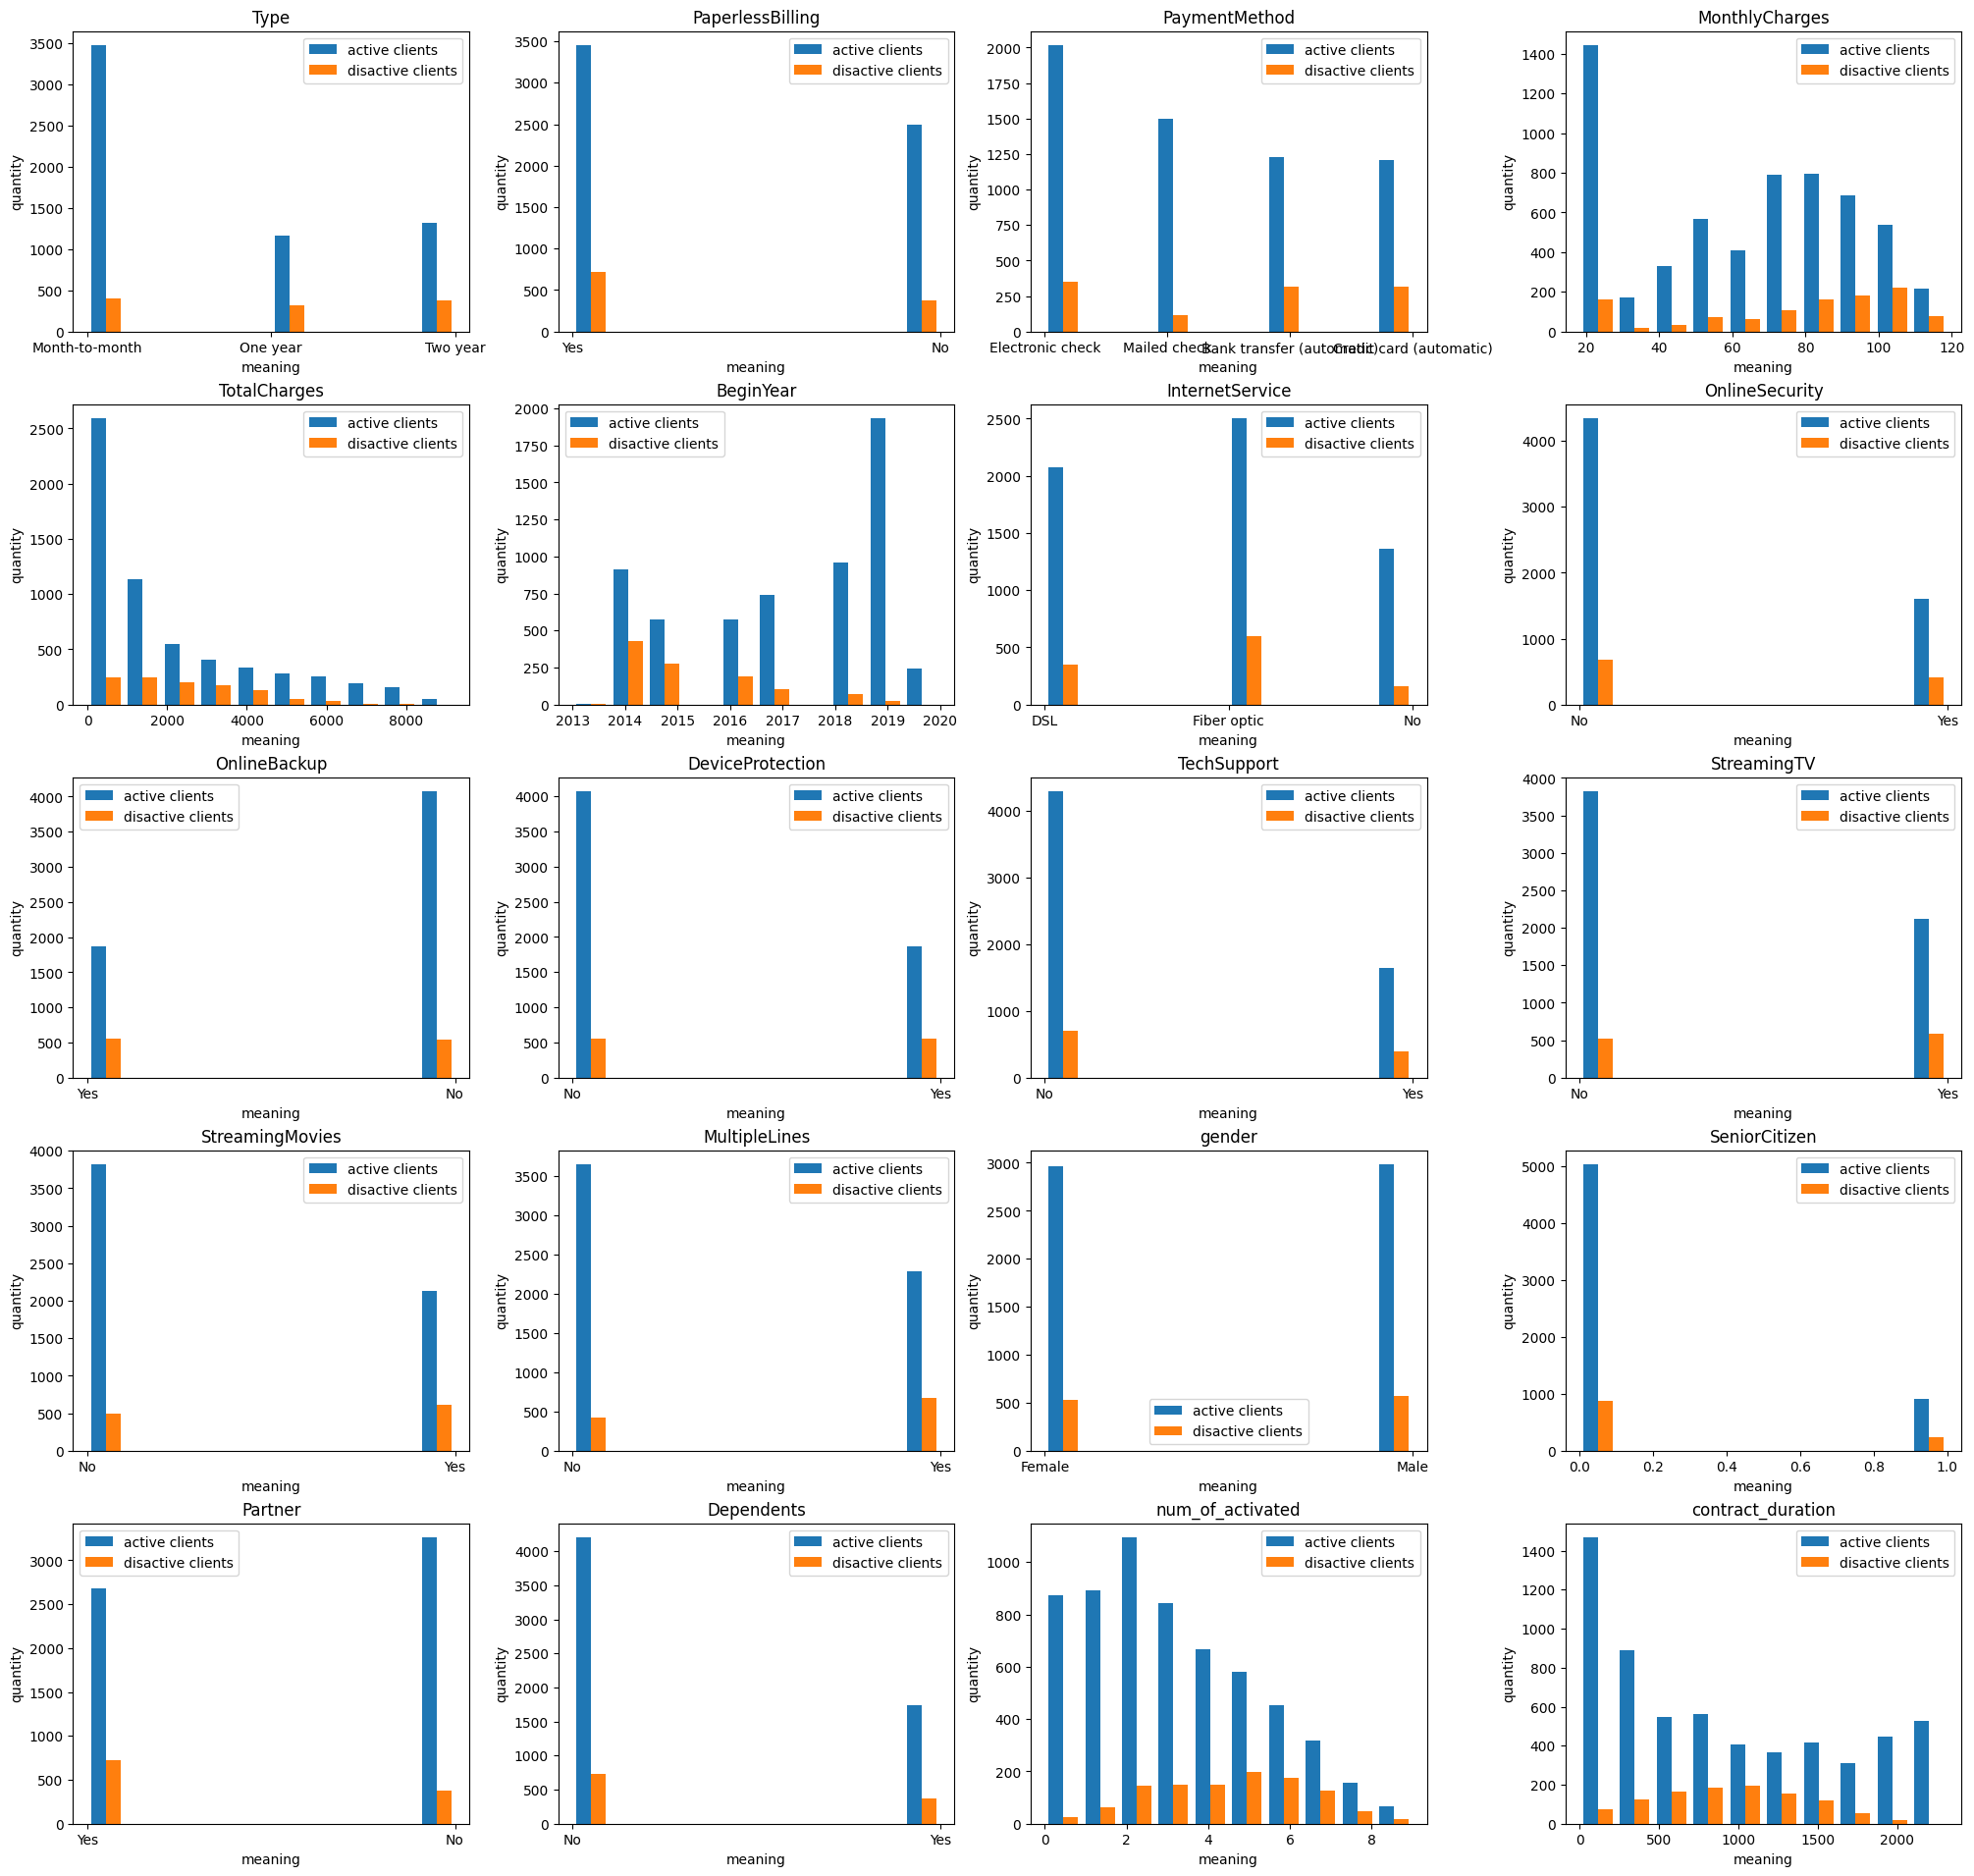

In [47]:
plt.figure(figsize=(20, 19), layout="constrained")
for i in range(len(columns_without_target)):
    plt.subplot(5, 4, i+1)
    column_target_draw(columns_without_target[i])

Теперь по каждой гистограмме можно выявить влияние отдельных признаков на факт ухода клиента.
- тип договора мало влияет на факт ухода из компании: несмотря на то, что в целом клиенты больше предпочитают помесячную оплату, среди ушедших клиентов виды договоров примерно равны. Среди клиентов, предпочитающих помесячный тип оплаты, процент ушедших ниже
- факт выставления счёта на электронную почту: среди ушедших клиентов больше тех, кто предпочитает такой способ - однако это соотвествует общему тренду в данных
- что касается методов оплаты, наиболее лояльны клиенты, придерживающиеся оплаты методом чека по почте. Возможно, это пожилые люди или просто консерваторы, предпочитающиеся стабильность, и потому хранящие верность одному провайдеру
- можно обратить внимание на разность распределений месячных расходов для уходящих клиентов: в целом основная масса клиентов сосредоточена в пике в районе 20 долларов (вероятно, ежемесячного платежа минимального тарифа) - и таких клиентов уходит довольно немного по сравнению с остающимися в этом ценовом сегменте. Примерно столько же по количеству уходит среди клиентов премиум-сегмента - тех, кто тратит более 80ти долларов в месяц - однако, это всего в три раза меньше оставшихся клиентов! То есть пользователи премиум сегмента - вероятно, те, кто пользуются расширенными пакетами и подключает дополнительные услуги, вероятно недовольны качеством сервиса.
- что касается общих расходов, здесь наблюдается явная закономерность: чем больше клиент потратил, тем меньше шанс, что он уйдёт
- любопытна также засисимость оттока клиентов от года подписания договора: старые клиенты уходят существенно больше новых! Количество ушедших падает в зависимости от года. Возможно, старые клиенты пользуются устаревшими невыгодными для них тарифами, и потому уходят?
- клиенты, пользующиеся опттическим типом подключения, уходят чаще DSL - стоит обратить внимание на качество предоставления данной услуги
- среди подключенных услуг: антивируса, облачного хранилища, фильмов и тд, какого-то явного дисбалаанса нет
- мужчины уходят чуть чаще женщин: вероятно, ввиду большей склонности к оптимизации процессов
- люди с наличием партнёров более склонны уходить
- наличие иждивенцов мотивирует к постоянству - люди менее склонны уходить
- можно ожидать высокую важность признака с количеством подключенных услуг - распределения очень отличаются. Среди активных коиентов пик приходится на 2-3 подключенные услуги, а среди ушедших - на 5-6 подключенных услуг
- важность признака длительности вероятно тоже будет довольно высокой: видно, что активные клиенты в целом разделяются на две категории: пришедшие недавно или наоборот, на заре создания компании. Для ушедших клиентов распределение этого признака отличается качественно: в основном уходят клиенты, пользовавшиеся услугами данного оператора около 3ёх лет.


В целом можно выделить следующую закономерность:
основная масса активных клиентов - люди, которые пользуются минимальным тарифом с помесячной оплатой и небольшим количеством подключенных дополнительных услуг или вовсе без них.
Большая часть клиентов, прекращающих пользоваться услугами компании - вероятно, клиенты премиум-сегмента с довольно большими ежемесячными расходами и большим количеством подключенных дополнительных услуг. Стоит отметить, что их договора в основном заключены довольно давно. Стоит обратить внимание на "старых" клиентов - может, пересмотреть их тариф и предложить более выгодный? Также возможно имеет смысл разработать пакеты более выгодного комплексного подключения услуг - в каждой конкретной услуге нет явного дисбаланса в целевом признаке, однако уходящие клиенты в основном пользуются большим количеством допуслуг. Характерный срок оттока клиентов - три года пользования услугами компании.

### Проверка на мультиколлинеарность

Изучим корреляцию между всеми признаками. Большинтсво признаков - качественные, поэтому классическая корреляция линейной зависимости между признаками здесь не подойдёт. Используем библиотек phik:

<Axes: >

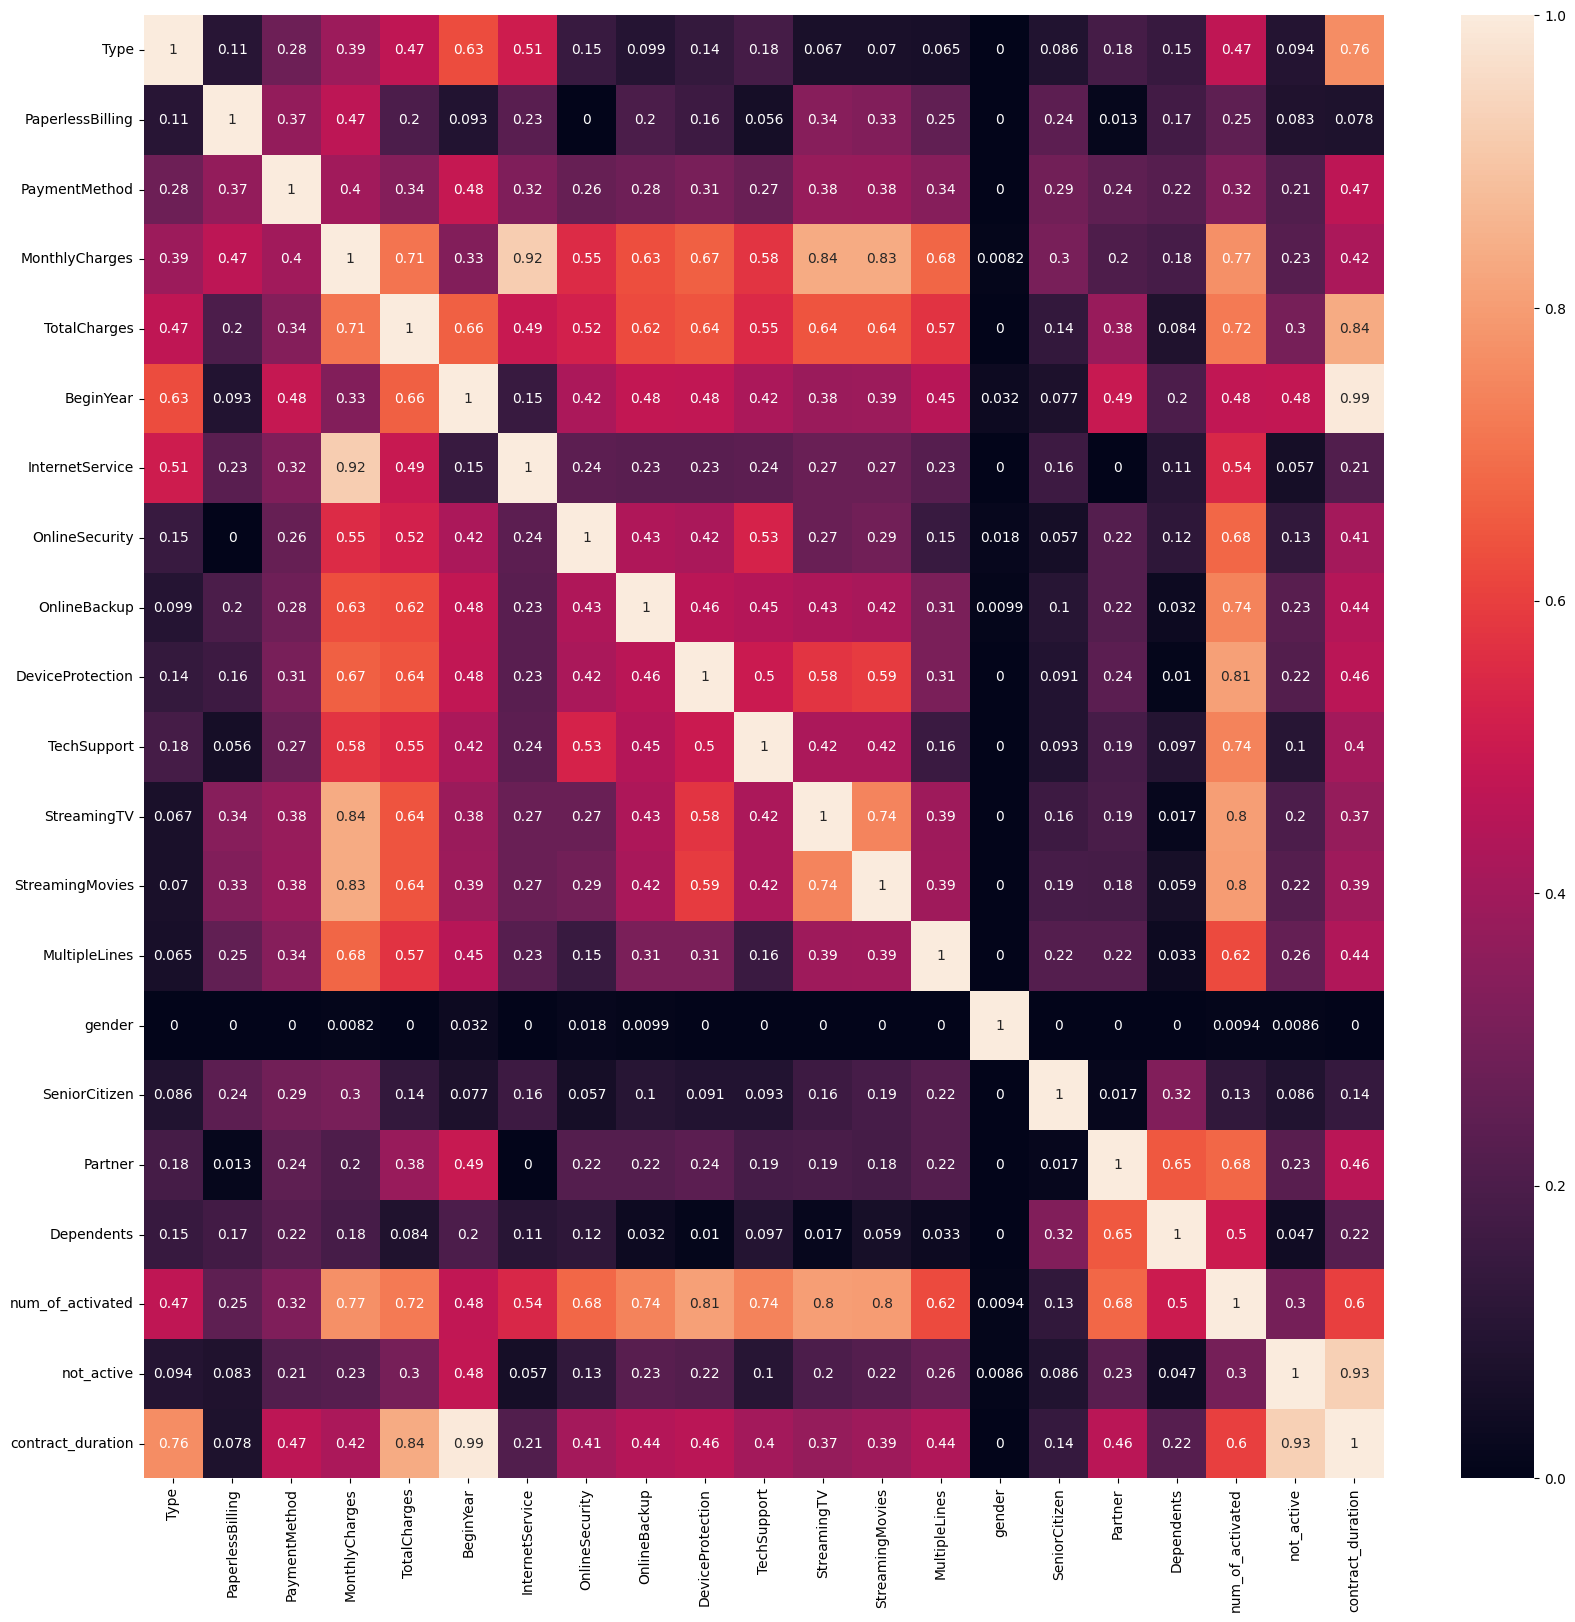

In [48]:
#выводим матрицу корреляций
plt.figure(figsize=(20, 19))
sns.heatmap(data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'num_of_activated']), annot=True)

Признаки, между которыми присутствует корреляция:
- ежемесячные расходы существенно зависят от типа подключения интернета,подключения фильмов и стримингового ТВ. Также наблюдается корреляция с количеством подключенных услуг и суммарными расходами
- общая потраченная сумма коррелирует с количеством подключенных услуг и ежемесячгыми расходами, что логично
- те, кто подключают стриминговое телевидение, в основном подключают и каталог фильмов: видимо, это киноманы. Возможно, имеет смысл разработки выгодного пакетного предложения для этих услуг
- есть некоторая корреляция между наличием партнёра и наличием иждивенцев
- количество подключенных услуг существенно коррелирует не только с качественными колонками о факте подключения конкретной услуги и ежемесячными расходами, но и с наличием партнёра
- можно ожидать важность признака года подписания договора при дальнейшем анализе обученной модели
- признак длительности контракта сильно коррелирует с целевым признаком, можно ожидать высокую важность этого признака и влияние на качества предсказаний модели
- важно отметить корреляцию признака длительности контакта с остальными признаками: характерна очень высокая корреляция с годом начала (близкая к единице!), высока корреляция с признаком общих расходов, присутствует некоторая корреляция с признаком типа подключения интернета.

Пока кажется, что признак количества подключённых услуг введён зря, так как сильно коррелирует с остальными столбцами подключенных услуг, и можно его удалить - но рациональнее как раз его оставить, а удалить все остальные столбцы с бинарным фактом подключения каждой конкретной услуги. Из столбцов с расходами (помесячные/общие) можно оставить только один. Между годом подписания контакта и длительностью тоже можно оставить только один признак, они сильно коррелируют межу собой. Пока сделаем так: оставим все признаки как есть, проведём обучение моделей, посмотрим на важность признаков - а потом уже попробуем изменить признаки и заново обучить модели.

### Изучение распределения признаков в зависимости от года подписания договора

Можно предположить измненеие стратегии компании в районе конца 2018-2019 года и переориентацию на привлечение бОльшего количества пользователе из эконом-сегмента - это заметно по резкому скачку количества подписанных договоров. Проверим эту гипотезу:


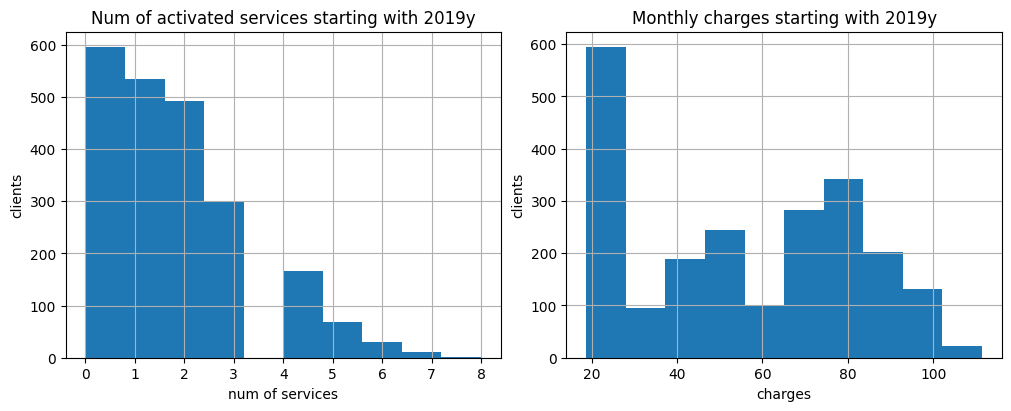

In [49]:
plt.figure(figsize=(10, 4), layout="constrained")
plt.subplot(1, 2, 1)
column_draw(data[data['BeginYear']>=2019]['num_of_activated'],
            'num of services', 'clients', 'Num of activated services starting with 2019y')
plt.subplot(1, 2, 2)
column_draw(data[data['BeginYear']>=2019]['MonthlyCharges'],
            'charges', 'clients', 'Monthly charges starting with 2019y')

В целом в основном это действительно клиенты с небольшим количеством подключенных услуг. Есть некоторое количество клиентов, платящих больше минимального платежа - возможно, пользователи более дорогих пакетов.

Посмотрим, как отличается картинка для пользователей, подписавших договор до 2019 года:

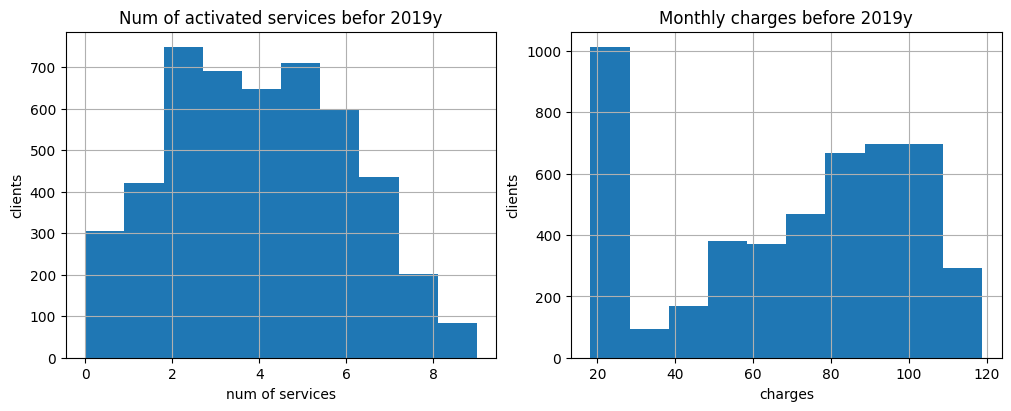

In [50]:
plt.figure(figsize=(10, 4), layout="constrained")
plt.subplot(1, 2, 1)
column_draw(data[data['BeginYear']<2019]['num_of_activated'],
            'num of services', 'clients', 'Num of activated services befor 2019y')
plt.subplot(1, 2, 2)
column_draw(data[data['BeginYear']<2019]['MonthlyCharges'],
            'charges', 'clients', 'Monthly charges before 2019y')

Вот оно!

Распределение по количеству сервисов выглядит совсем иначе, распределение ежемесяных платежей тоже отличается: то есть люди существенно чаще подключали дополнительные сервисы. Возможно, новые пользователи чаще пользуются новыми пакетами услуг, введёнными компанией в 2019ом году. Посмотрим, как это повлияло на доходы компании: выведем таблицу, демонстрирующую суммарный ежемесячный доход компании от активных клиентов в зависимости от года подписания договора:

In [51]:
data[data['not_active']==0].groupby('BeginYear')['MonthlyCharges'].sum()

BeginYear
2013       624.75
2014     68704.05
2015     39588.30
2016     37588.40
2017     47883.05
2018     58605.00
2019    110658.50
2020      9288.40
Name: MonthlyCharges, dtype: float64

Гипотеза подтвердилась: ежемесячная прибыль от тех, кто пришёл в 2019ом году, больше почти в два раза! Значит, стратегия компании отлично сработала.

### Подбор параметров для обучения моделей

Помним, что особенность датасета с признаками - большое количество категориальных столбцов и минимальное значение количественных. Можно провести оценку прогнозируемой важности признаков статистическими методами - но пока ограничимся результатами проверки на мультиколлинеарность.

- у нас два сильно коррелирующих признака: год подписания договора и длительность контракта. Оставлять их оба нельзя, так как это утечка целевого признака. Смотрим на корреляцию целевого признака: зависимость от длительности контракта выше - значит, можно длительность оставить, а год - нет.

Однако, проведём эксперимент и рассмотрим два варианта: по датасету на каждый признак, и сравним значение метрик для нескольких моделей (возможно, не всех для экономии вычислительных ресурсов)

In [52]:
data_duration = data.drop('BeginYear', axis=1)
data_year = data.drop('contract_duration', axis=1)

Вывод по разделу:

Проведён исследовательский анализ данных. Распределение каждого признака изучено в разрезе значения целевого признака - ушёл ли клиент из компании или является активным пользователем. Среди ключевых параметров, влияющих на отток клиентов, можно отметить ежемесячные расходы и количество подключенных услуг: клиенты премиум-сегмента, пользующиеся широким спектром услуг, значительно чаще уходят. Также можно отметить, что часто уходят клиенты, которые заключали договор более двух лет назад - возможно, стоит провести актуализацию тарифных планов, перевод старых клиентов на более выгодные предложения и тд. Наличие партнёра отрицательно сказывается на факт оттока, а иждивенцев - положительно. Мужчины чуть больше склонны к смене провайдера. Наиболее лояльные клиенты - те, которые заключили договор недавно, пользуются минимумом дополнительных услуг (не более трёх) и тратят порядка 20 долларов в месяц - вероятно, это соответствует ежемесячному платежу минимального тарифа.

Также продемоентрировано, что 2019ом году, скорее всего, проведено изменение стратегии, и компания стала больше ориентироваться на клиентов, нуждающихся в минимальном пакете. Возможно, были разработаны новые тарифные планы с комплексом дополнительных услуг - это видно по сравнению распределений ежемесячных расходов и количества подключенных услуг: всё ещё есть клиенты приемиум-сегмента с расходами  порядка 80-100 долларов в месяц, однако количество дополнительно подключенных услуг существенно снизилось. Исходя из роста ежемесячной прибыли компании почти в два раза от таких клиентов - эта стратегия целесообразна.

Проведено дополнительное рассмотрение признаков. Длительность контракта коррелирует с целевым признаком выше года подписания. В то же время оставлять оба этих признака нельзя, так как совместно они приводят к утечке значения целевого признака. Выбрано провести обучение моделей на двух вариантах датасетов: с удалением признака и с удалением года.



## Подготовка данных к обучению моделей

### Разделение данных на выборки

<div class="alert alert-block alert-info">

Обновление начиная с этого раздела: качество обучения на наборе с длительностью без года хуже, чем с годом без длительности - поэтому два варианта обучающих данных. Потом - сравнение.
    
</div>

Для дальнейшего обучения моделей разбиваем данные на обучающую и тестовую выборки в соотношении 3:1 соответственно. Отдельную валидационную выборку отделять не будем: данных немного, будем обучать модели кросс-валидацией. Также выделяем отдельно целевой признак.

In [53]:
#отщепляем признаки и целевой признак
features_year = data_year.drop('not_active', axis=1)
target_year = data_year['not_active']

features_dur = data_duration.drop('not_active', axis=1)
target_dur = data_duration['not_active']

In [54]:
#и делим на обучающую и тестовую выборки
x_year_train, x_year_test, y_year_train, y_year_test = train_test_split(
    features_year, target_year, test_size=0.25, random_state=RANDOM_STATE
)

x_dur_train, x_dur_test, y_dur_train, y_dur_test = train_test_split(
    features_dur, target_dur, test_size=0.25, random_state=RANDOM_STATE
)

### Масштабирование и кодирование признаков

Дальше нужно масштабировать количественные признаки, а качественные - закодировать.
Будем работать с двумя кодировками -  OHE для логистической регрессии и OE для моделей случайного леса и бустингов. ОЕ выгоднее с точки зрения экономии вичислительных ресурсов за счёт сохранения количества признаков, но не подходит для линейных моделей - поэтому пишем два рансформера для разных моделей.

Масштабирование данных сразу включим в оба трансформера. Для выбора столбцов будем использовать column_selector с фильтром по типу значений в нём.

Вариантов обучающих выборок у нас теперь два, но за счёт того, что выбор столбцов для трансформера реализован на базе ColumnSelector, основанный на фильтре через типы данных - дополнительные трансформеры не нужны.

Создаём ОНЕ трансформер:

In [55]:
ohe_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        make_column_selector(dtype_exclude=np.number)
    ),
    (
        StandardScaler(),
        make_column_selector(dtype_include=np.number)
    ),
    remainder='passthrough'
)


In [56]:
#проверим, что получилось на выходе для какого-то обучающего набора
x_dur_train_ohe = pd.DataFrame(ohe_transformer.fit_transform(x_dur_train),
                           columns=ohe_transformer.get_feature_names_out())
ds_describe(x_dur_train_ohe)

Размер датасета = (5282, 23)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 23 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   onehotencoder__Type_One year                          5282 non-null   float64
 1   onehotencoder__Type_Two year                          5282 non-null   float64
 2   onehotencoder__PaperlessBilling_Yes                   5282 non-null   float64
 3   onehotencoder__PaymentMethod_Credit card (automatic)  5282 non-null   float64
 4   onehotencoder__PaymentMethod_Electronic check         5282 non-null   float64
 5   onehotencoder__PaymentMethod_Mailed check             5282 non-null   float64
 6   onehotencoder__InternetService_Fiber optic            5282 non-null   float64
 7   onehotencoder__InternetService_No                     5282 non-null

,onehotencoder__Type_One year,onehotencoder__Type_Two year,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_Yes,...,onehotencoder__StreamingMovies_Yes,onehotencoder__MultipleLines_Yes,onehotencoder__gender_Male,onehotencoder__Partner_Yes,onehotencoder__Dependents_Yes,standardscaler__MonthlyCharges,standardscaler__TotalCharges,standardscaler__SeniorCitizen,standardscaler__num_of_activated,standardscaler__contract_duration
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,-0.462496,-0.629752,-0.444366,-0.094234,-0.644490
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-1.471722,-0.697695,-0.444366,-1.398372,0.067847
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.157028,-0.834602,2.250399,-0.963659,-1.088241
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.344450,1.652909,-0.444366,0.775191,1.044391
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.635697,-0.978182,-0.444366,-1.398372,-1.266325


Поскольку первая колонка при кодировании удаляется во избежание дамми-ловушки - количество признаков выросло не так уж сильно: у нас всего два категориальных признакас более чем двумя вариантами категорий: это тип контакта и способ оплаты.

Теперь повторим путь для Ordinal Encoder кодировщика.

In [57]:
oe_transformer = make_column_transformer(
    (
        OrdinalEncoder(),
        make_column_selector(dtype_exclude=np.number)
    ),
    (
        StandardScaler(),
        make_column_selector(dtype_include=np.number)
    ),
    remainder='passthrough'
)


In [58]:
#проверим, что получилось на выходе
x_year_train_oe = pd.DataFrame(oe_transformer.fit_transform(x_year_train),
                           columns=oe_transformer.get_feature_names_out())
ds_describe(x_year_train_oe)

Размер датасета = (5282, 19)
Количество значений и тип данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ordinalencoder__Type              5282 non-null   float64
 1   ordinalencoder__PaperlessBilling  5282 non-null   float64
 2   ordinalencoder__PaymentMethod     5282 non-null   float64
 3   ordinalencoder__InternetService   5282 non-null   float64
 4   ordinalencoder__OnlineSecurity    5282 non-null   float64
 5   ordinalencoder__OnlineBackup      5282 non-null   float64
 6   ordinalencoder__DeviceProtection  5282 non-null   float64
 7   ordinalencoder__TechSupport       5282 non-null   float64
 8   ordinalencoder__StreamingTV       5282 non-null   float64
 9   ordinalencoder__StreamingMovies   5282 non-null   float64
 10  ordinalencoder__MultipleLines     5282 non-null   float64


,ordinalencoder__Type,ordinalencoder__PaperlessBilling,ordinalencoder__PaymentMethod,ordinalencoder__InternetService,ordinalencoder__OnlineSecurity,ordinalencoder__OnlineBackup,ordinalencoder__DeviceProtection,ordinalencoder__TechSupport,ordinalencoder__StreamingTV,ordinalencoder__StreamingMovies,ordinalencoder__MultipleLines,ordinalencoder__gender,ordinalencoder__Partner,ordinalencoder__Dependents,standardscaler__MonthlyCharges,standardscaler__TotalCharges,standardscaler__BeginYear,standardscaler__SeniorCitizen,standardscaler__num_of_activated
0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.462496,-0.629752,0.566365,-0.444366,-0.094234
1,2.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.471722,-0.697695,0.059496,-0.444366,-1.398372
2,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.157028,-0.834602,1.073234,2.250399,-0.963659
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.344450,1.652909,-0.954242,-0.444366,0.775191
4,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.635697,-0.978182,1.580104,-0.444366,-1.398372


Ожидаемо количество признаков не изменилось.

### Борьба с дисбалансом

Напомним, что в целевом признаке присутствует существенный дисбаланс:

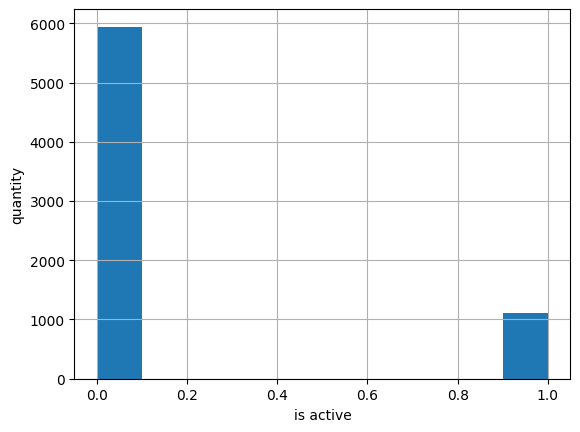

In [59]:
column_draw(data['not_active'], xlabel='is active', ylabel='quantity')

То есть ушедшие клиенты составляют примерно 15 процентов датасета. Из возможных методов борьбы с дисбалансом:
- уменьшение выборки: точно применять не будем, у нас и так довольно немного данных
- увеличение выборки: техника upsampling
- комбинация этих методов - SmotoTomek. В нашем случае выбранная метрика устойчива к дисбалансу, поэтому применять не будем
- взвешивание классов: будем применять в тех моделях, которые это позволяют сделать внутренними методами (например, в регрессии)
- изменение порога классификации.

Итого, сделаем так: применим взвешивание классов, а если метрика будет получаться недостаточно высокой - попробуем увеличение выборки и/или изменение порога классификации

Вывод по разделу:

Данные разделены на обучающую и тестовую выборку в пропорции 3:1 соответственно. Ввиду небольшого количества данных отдельная валидационная выбока не выделяется - модели будут обучены с использованием кросс-валидации. Выделен целевой признак. Для признаков созданы трансформеры - OneHotEncoder для линейных моделей, OrdinalEncoder для "деревянных". В обоих случаях проведено масштабирование количественных признаков.

##  Построение, оптимизация и обучение моделей

Будем исследовать следующие модели: логистическая регрессия, модель Ridge, SGD классификатор, LightGBM, модель случайного леса (отдельное дерево пробовать не будем), градиентный бустинг, CatBoost. Обучение каждой модели будем проводить внутри пайплайна с кросс-валидацией - это позволит обучать кодировщик на только на обучающей выборке на каждой итерации кросс-валидации.

Идеологически обучение линейных моделей необходимо проводить на некоррелирующем наборе признаков, но пользуемся конструкторами моделей из бибилотиеки scikit-learn со встроенной регуляризацией, поэтому можно обучать на полном наборе признаков.

Важный комментарий:

Обучение моделей и подбор гиперпараметров проводился в Google Colab. Затем интервал каждого гиперпараметра уменьшен таким образом, чтобы включать в себя уже подобранное в цикле значение. Это сделано для того, продемоентрировать механизм подбора гиперпараметров, но не умереть от ожидания при повторном запуске блокнота.

In [60]:
# список категориальных столбцов будет одинаков для обоих датасетов, признаки "под вопросом" - количественные
cat_columns = list(set(data.columns) -
                   set(['MonthlyCharges', 'TotalCharges', 'BeginYear',
                        'num_of_activated', 'contract_duration', 'not_active']))

### Логистическая регрессия

In [61]:
def train_vs(transformer, model, x1=x_dur_train, y1=y_dur_train, x2=x_year_train, y2=y_year_train, f_params={}):
  print('Для обучающего набора c длительностью контракта:')
  best_score_1, best_params_1, best_time_1 = model_pipeline(transformer,
                                                            model,
                                                            x1, y1,
                                                            params=f_params)
  print('')
  print('Для обучающего набора с годом подписания контракта:')
  best_score_2, best_params_2, best_time_2 = model_pipeline(transformer,
                                                            model,
                                                            x2, y2,
                                                            params=f_params)

  return best_score_1, best_params_1, best_time_1, best_score_2, best_params_2, best_time_2

In [62]:
lr_dur_score, lr_dur_params, lr_dur_time, lr_year_score, lr_year_params, lr_year_time = \
  train_vs(ohe_transformer, LogisticRegression(random_state=RANDOM_STATE,
                                                  class_weight='balanced'))

Для обучающего набора c длительностью контракта:
Для модели LogisticRegression(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.77
время обучения =0.0975, параметры модели:{}

Для обучающего набора с годом подписания контракта:
Для модели LogisticRegression(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.917
время обучения =0.089, параметры модели:{}


По модели логистической регрессии видно, что признак года подписания договора работает лучше.

 ### Ridge

In [63]:
ridge_params = {
    'ridge__alpha': np.arange(0, 0.1, 0.01),
}

In [64]:
ridge_dur_score, ridge_dur_params, ridge_dur_time, ridge_year_score, ridge_year_params, ridge_year_time = \
  train_vs(ohe_transformer, Ridge(random_state=RANDOM_STATE), f_params=ridge_params)

Для обучающего набора c длительностью контракта:
Для модели Ridge(random_state=300623) метрика ROC-AUC =0.77
время обучения =0.0415, параметры модели:{'ridge__alpha': 0.0}

Для обучающего набора с годом подписания контракта:
Для модели Ridge(random_state=300623) метрика ROC-AUC =0.912
время обучения =0.094, параметры модели:{'ridge__alpha': 0.02}


### SGDClassifier

In [65]:
sgd_params = {
    'sgdclassifier__alpha': np.arange(0.01, 0.15, 0.01),
}


In [66]:
sgd_dur_score, sgd_dur_params, sgd_dur_time, sgd_year_score, sgd_year_params, sgd_year_time = \
  train_vs(ohe_transformer, SGDClassifier(random_state=RANDOM_STATE, class_weight='balanced'), f_params=sgd_params)

Для обучающего набора c длительностью контракта:
Для модели SGDClassifier(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.764
время обучения =0.0529, параметры модели:{'sgdclassifier__alpha': 0.01}

Для обучающего набора с годом подписания контракта:
Для модели SGDClassifier(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.917
время обучения =0.0498, параметры модели:{'sgdclassifier__alpha': 0.01}


### LightGBM

In [67]:
lgbm_params = {'lgbmclassifier__n_estimators': np.arange(1200, 1500, 50),
            'lgbmclassifier__max_depth': np.arange(1, 4, 1)}

In [68]:
lgbm_dur_score, lgbm_dur_params, lgbm_dur_time, lgbm_year_score, lgbm_year_params, lgbm_year_time = \
  train_vs(oe_transformer,  LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'), f_params=lgbm_params)

Для обучающего набора c длительностью контракта:
Для модели LGBMClassifier(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.899
время обучения =1.98, параметры модели:{'lgbmclassifier__max_depth': 2, 'lgbmclassifier__n_estimators': 1450}

Для обучающего набора с годом подписания контракта:
Для модели LGBMClassifier(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.941
время обучения =2.16, параметры модели:{'lgbmclassifier__max_depth': 2, 'lgbmclassifier__n_estimators': 1200}


Потестируем работу модели при ручном определении категориальных столбцов:

In [69]:
lgbm_cat_params = {'lgbmclassifier__n_estimators': np.arange(1400, 1500, 50),
            'lgbmclassifier__max_depth': np.arange(2, 6, 2)}

#lgbm_cat_best_score, lgbm_cat_best_params, lgbm_cat_best_time = model_pipeline(oe_transformer,
#                                LGBMClassifier(random_state=RANDOM_STATE,
#                                               class_weight='balanced',
#                                               categorial_feature=cat_columns),
#                                x_train, y_train,
#                                params=lgbm_cat_params)

In [70]:
lgbm_cat_params = {'lgbmclassifier__n_estimators': np.arange(1100, 1500, 50),
            'lgbmclassifier__max_depth': np.arange(1, 3, 1)}

lgbm_cat_model =  LGBMClassifier(random_state=RANDOM_STATE,
                                               class_weight='balanced',
                                               categorial_feature=cat_columns)

In [71]:
lgbm_cat_dur_score, lgbm_cat_dur_params, lgbm_cat_dur_time, lgbm_cat_year_score, lgbm_cat_year_params, lgbm_cat_year_time = \
  train_vs(oe_transformer,  lgbm_cat_model, f_params=lgbm_cat_params)

Для обучающего набора c длительностью контракта:
Для модели LGBMClassifier(categorial_feature=['OnlineBackup', 'Type', 'SeniorCitizen',
                                   'gender', 'MultipleLines',
                                   'DeviceProtection', 'Partner', 'Dependents',
                                   'StreamingTV', 'PaymentMethod',
                                   'StreamingMovies', 'TechSupport',
                                   'OnlineSecurity', 'InternetService',
                                   'PaperlessBilling'],
               class_weight='balanced', random_state=300623) метрика ROC-AUC =0.899
время обучения =0.654, параметры модели:{'lgbmclassifier__max_depth': 2, 'lgbmclassifier__n_estimators': 1450}

Для обучающего набора с годом подписания контракта:
Для модели LGBMClassifier(categorial_feature=['OnlineBackup', 'Type', 'SeniorCitizen',
                                   'gender', 'MultipleLines',
                                   'DeviceProtection', 'Partn

В общем, модель хорошо справляется самостоятельно - с точностью до тысячных разницы в метрике нет

### RandomForest

In [72]:
rf_params = {'randomforestclassifier__n_estimators': np.arange(150, 250, 50),
            'randomforestclassifier__max_depth': np.arange(6, 10, 2)}


In [73]:
rf_dur_score, rf_dur_params, rf_dur_time, rf_year_score, rf_year_params, rf_year_time = \
  train_vs(oe_transformer,
           RandomForestClassifier(random_state=RANDOM_STATE,class_weight='balanced'),
           f_params=rf_params)

Для обучающего набора c длительностью контракта:
Для модели RandomForestClassifier(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.831
время обучения =0.976, параметры модели:{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 200}

Для обучающего набора с годом подписания контракта:
Для модели RandomForestClassifier(class_weight='balanced', random_state=300623) метрика ROC-AUC =0.9
время обучения =0.902, параметры модели:{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 200}


### Градиентный бустинг

In [74]:
#gb_params = {'gradientboostingclassifier__n_estimators': np.arange(400, 500, 50),
#            'gradientboostingclassifier__max_depth': np.arange(2, 6, 2)}

#gb_best_score, gb_best_params, gb_best_time = model_pipeline(oe_transformer,
#                        GradientBoostingClassifier(random_state=RANDOM_STATE),
#                        x_train, y_train,
#                        params=gb_params)

In [75]:
gb_params = {'gradientboostingclassifier__n_estimators': np.arange(400, 500, 50),
            'gradientboostingclassifier__max_depth': np.arange(2, 6, 2)}

In [76]:
gb_dur_score, gb_dur_params, gb_dur_time, gb_year_score, gb_year_params, gb_year_time = \
  train_vs(oe_transformer,
            GradientBoostingClassifier(random_state=RANDOM_STATE),
           f_params=gb_params)

Для обучающего набора c длительностью контракта:
Для модели GradientBoostingClassifier(random_state=300623) метрика ROC-AUC =0.903
время обучения =5.21, параметры модели:{'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 450}

Для обучающего набора с годом подписания контракта:
Для модели GradientBoostingClassifier(random_state=300623) метрика ROC-AUC =0.944
время обучения =2.67, параметры модели:{'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__n_estimators': 450}


### CatBoost

Начнём с того, чтобы обучить CatBoost с использованием готового пайплайна с трансформером и масштабированием, но без подбора гиперпараметров:

In [77]:
cb_dur_score, cb_dur_params, cb_dur_time, cb_year_score, cb_year_params, cb_year_time = \
  train_vs(oe_transformer,
           CatBoostClassifier(random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced')
           )

Для обучающего набора c длительностью контракта:
Для модели <catboost.core.CatBoostClassifier object at 0x7e71f797e920> метрика ROC-AUC =0.875
время обучения =5.41, параметры модели:{}

Для обучающего набора с годом подписания контракта:
Для модели <catboost.core.CatBoostClassifier object at 0x7e71f797e920> метрика ROC-AUC =0.942
время обучения =3.96, параметры модели:{}


Теперь попробуем отдать модели данные,  прошедшие только базовую предобработку, поскольку внутри модели уже есть встроенный преобразователь данных для категориальных признаков. Оптимизацию гиперпараметров пока тоже не делаем.

In [78]:
model_cb_cat = CatBoostClassifier(random_state=RANDOM_STATE,
                                 cat_features=cat_columns,
                                  auto_class_weights='Balanced',
                                  silent=True)

In [79]:
cb_cat_dur_score, cb_cat_dur_params, cb_cat_dur_time, cb_cat_year_score, cb_cat_year_params, cb_cat_year_time = \
  train_vs(None,
           model_cb_cat
           )

Для обучающего набора c длительностью контракта:
Для модели <catboost.core.CatBoostClassifier object at 0x7e71f797ded0> метрика ROC-AUC =0.866
время обучения =12.7, параметры модели:{}

Для обучающего набора с годом подписания контракта:
Для модели <catboost.core.CatBoostClassifier object at 0x7e71f797ded0> метрика ROC-AUC =0.945
время обучения =11.3, параметры модели:{}


Если сравнивать эти две модели, можно заметить, что качество обучения у них соизмеримо (до тысячных долей), а скорость обучения отличается почти в два раза: встроенный в CatBoost кодификатор работает медленнее.

Из всех рассмотренных моделей CatBoost показывает одно из самых высоких значений метрики. Значит, придётся запускать ещё один пайплайн - с оптимизацией гиперпараметров :)

Кодировщик будем использовать пользовательский, он оказался быстрее.

In [80]:
cb_opt_params = {'catboostclassifier__learning_rate': np.arange(.04, .06, .01),
            'catboostclassifier__depth': np.arange(2, 6, 2),
            'catboostclassifier__l2_leaf_reg': np.arange(3, 9, 2)}

model_cb_opt =  CatBoostClassifier(random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced')


In [81]:
cb_opt_dur_score, cb_opt_dur_params, cb_opt_dur_time, cb_opt_year_score, cb_opt_year_params, cb_opt_year_time = \
  train_vs(oe_transformer,
           model_cb_opt,
           f_params=cb_opt_params)

Для обучающего набора c длительностью контракта:
Для модели <catboost.core.CatBoostClassifier object at 0x7e720100ba30> метрика ROC-AUC =0.901
время обучения =3.72, параметры модели:{'catboostclassifier__depth': 4, 'catboostclassifier__l2_leaf_reg': 3, 'catboostclassifier__learning_rate': 0.05}

Для обучающего набора с годом подписания контракта:
Для модели <catboost.core.CatBoostClassifier object at 0x7e720100ba30> метрика ROC-AUC =0.947
время обучения =1.72, параметры модели:{'catboostclassifier__depth': 2, 'catboostclassifier__l2_leaf_reg': 7, 'catboostclassifier__learning_rate': 0.05}


По сравнению с моделью CatBoost, обученной с тем же польщовательским кодировщиком, качество обучения модели практически не поменялось (выше на тысячные), зато существенно изменилась скорость обучения модели: при подборе гиперпараметров оно существенно снизилось.

### Сравнение моделей

Теперь проведём сравнение всех обученных моделей. Сравнение проведём в два этапа:
1. значение целевой метрикидля каждой рассмотренной модели, обученной на двух вариантах обучающий выборок - с годом подписания и с длительностью контракте

2. для выбранного обучаюзего набора рассмотрим две характеристики: метрику ROC-AUC и время обучения модели.

In [82]:
models_ds_comp = pd.DataFrame({
    'Model': ['LogRegression', 'Ridge', 'SGDClassifier', 'LightGBM', 'LightGBT_inner_transformer',\
              'RandomForest', 'GradBoosting', 'CatBoost_oe', 'CatBoost_kit', 'CatBoost_oe_optimized'],
    'ROC-AUC duration': [lr_dur_score, ridge_dur_score, sgd_dur_score, lgbm_dur_score, lgbm_cat_dur_score,\
                rf_dur_score, gb_dur_score, cb_dur_score, cb_cat_dur_score, cb_opt_dur_score],
    'ROC-AUC year': [lr_year_score, ridge_year_score, sgd_year_score, lgbm_year_score, lgbm_cat_year_score,\
                rf_year_score, gb_year_score, cb_year_score, cb_cat_year_score, cb_opt_year_score],
})

In [83]:
models_ds_comp

,Model,ROC-AUC duration,ROC-AUC year
0,LogRegression,0.770327,0.917383
1,Ridge,0.769509,0.911899
2,SGDClassifier,0.764323,0.916577
3,LightGBM,0.898886,0.940897
4,LightGBT_inner_transformer,0.898886,0.941375
5,RandomForest,0.830592,0.900198
6,GradBoosting,0.902757,0.944439
7,CatBoost_oe,0.874721,0.942227
8,CatBoost_kit,0.865966,0.945337
9,CatBoost_oe_optimized,0.900740,0.947020


Хорошо видно, что на использовании обучающей выборки с признаком года подписания договора величина метрики получается выше, сравнимое качество обучения получается только для градиентного бустинга и модели CatBoost с оптимизацией гиперпараметров.

На выбор обучающего набора признаков существенное влияние оказывает предполагаемый временной горизонт жизненного цикла модели: в случае, если предполагается использовать модель без переобучения и модификаций неограниченное время - длительность контракта надёжнее, если же акцент предполагается сделать на более точное прогнозирование в ближайший год-полтора - использование года даст более качественный результат.

В рамках текущей постановки задачи о максимизации целевой метрики остановимся на втором варианте.

Проведём сравнение всех обученных моделей и затраченного на обучение времени:

In [84]:
models_time = pd.DataFrame({
    'Model': ['LogRegression', 'Ridge', 'SGDClassifier', 'LightGBM', 'LightGBT_inner_transformer',\
              'RandomForest', 'GradBoosting', 'CatBoost_oe', 'CatBoost_kit', 'CatBoost_oe_optimized'],
    'ROC-AUC': [lr_year_score, ridge_year_score, sgd_year_score, lgbm_year_score, lgbm_cat_year_score,\
                rf_year_score, gb_year_score, cb_year_score, cb_cat_year_score, cb_opt_year_score],
    'fitting_time': [lr_year_time, ridge_year_time, sgd_year_time, lgbm_year_time, lgbm_cat_year_time,\
                rf_year_time, gb_year_time, cb_year_time, cb_cat_year_time, cb_opt_year_time],
})

In [85]:
models_time

,Model,ROC-AUC,fitting_time
0,LogRegression,0.917383,0.089036
1,Ridge,0.911899,0.094025
2,SGDClassifier,0.916577,0.049845
3,LightGBM,0.940897,2.164187
4,LightGBT_inner_transformer,0.941375,0.509531
5,RandomForest,0.900198,0.901648
6,GradBoosting,0.944439,2.666625
7,CatBoost_oe,0.942227,3.960104
8,CatBoost_kit,0.945337,11.284140
9,CatBoost_oe_optimized,0.947020,1.717839


Наиболее важный критерий при выборе финальной модели - качество обучения, то есть значение полученной метрики, хорошо также учитывать время обучения, поскольку скорость работы модели для бизнес-задач часто важна, а вычислительные мощности могут быть ограничены.

Наиболее оптимальной является модель CatBoost с оптимизацией гиперпараметров и обучением на данных, преобразованных пользовательским кодировщиком - она показывает наиболее высокое качество обучения при конкурентноспособном времени обучения.

Соизмеримое качество метрики показывают модели градиентного бустинга - однако, они работает медленнее.

Дополнительное преимущество модели CatBoost - она показывает соизмеримо высокое качество на наборе признаков с длительностью контракта (ROC-AUC = 0.9 на обучающей выборке)

Вывод по разделу:

Проведено обучение выбранных моделей на обучающей выборке с использованием кросс-валидации. Для каждой модели, если это возможно, проведена оптимизация гиперпараметров через призму максимизации выбранной метрики ROC-AUC. Получена комбинация гиперпараметров наиболее удачной конфигурации. Для каждой модели учитывалось также время выполнения. Наиболее оптимальной является модель CatBoost c подбором гиперпараметров, обученная на датасете с признаком года подписания договора, преобразованном пользовательским кодировщиком. В такой конфигурации ROC-AUC на обучающей выборке = 0.947.

## Тестирование модели

### Сравнение со случайной моделью

Тестирование полученной модели начнём со сравнения со случайной: если бы значение целевого признака выставилось случайно - 0 или 1.

In [86]:
roc_auc_ran_model = roc_auc_score(y_year_train, np.random.randint(0, 2, len(y_year_train)))
print(f'Метрика ROC-AUC для случайной модели на обучающей выборке ={roc_auc_ran_model:.3}')

Метрика ROC-AUC для случайной модели на обучающей выборке =0.481


Видно, что метрика для случайной модели существенно ниже полученной метрики для модели CatBoost - значит, применение модели рационально, поскольку она работает намного точнее случайного угадывания.

### Изучение полученной модели

Теперь изучим полученную модель: возможно, её можно оптимизировать ещё. С этой целью изучим важность признаков - возможно, можно сократить количество признаков без ущерба для качества предсказаний и таким образом снизить нагрузку на вычислительные ресурсы. На финальной версии полученной модели для повышения интерпретируемости результата планируется нарисовать  ROC-кривую, вычисление итогового значения метрики на тестовой выборке, а также вычисление дополнительных метрик: точности, полноты и метрики f1.

In [87]:
# Собираем модель CatBoost с конфигурацией гиперпараметров, полученной на этапе оптимизации
cb_model_final = CatBoostClassifier(depth=2,
                                    l2_leaf_reg=7,
                                    learning_rate=0.05,
                                    random_state=RANDOM_STATE,
                                    silent=True,
                                    auto_class_weights='Balanced')



In [88]:
cb_model_final.fit(x_year_train_oe, y_year_train)

#### Важность признаков

Изучим важность признаков предобученной модели - возможно, часть признаков можно удалить, оптимизировав тем самым процесс обучения модели - увеличив метрику или уменьшив время обучения

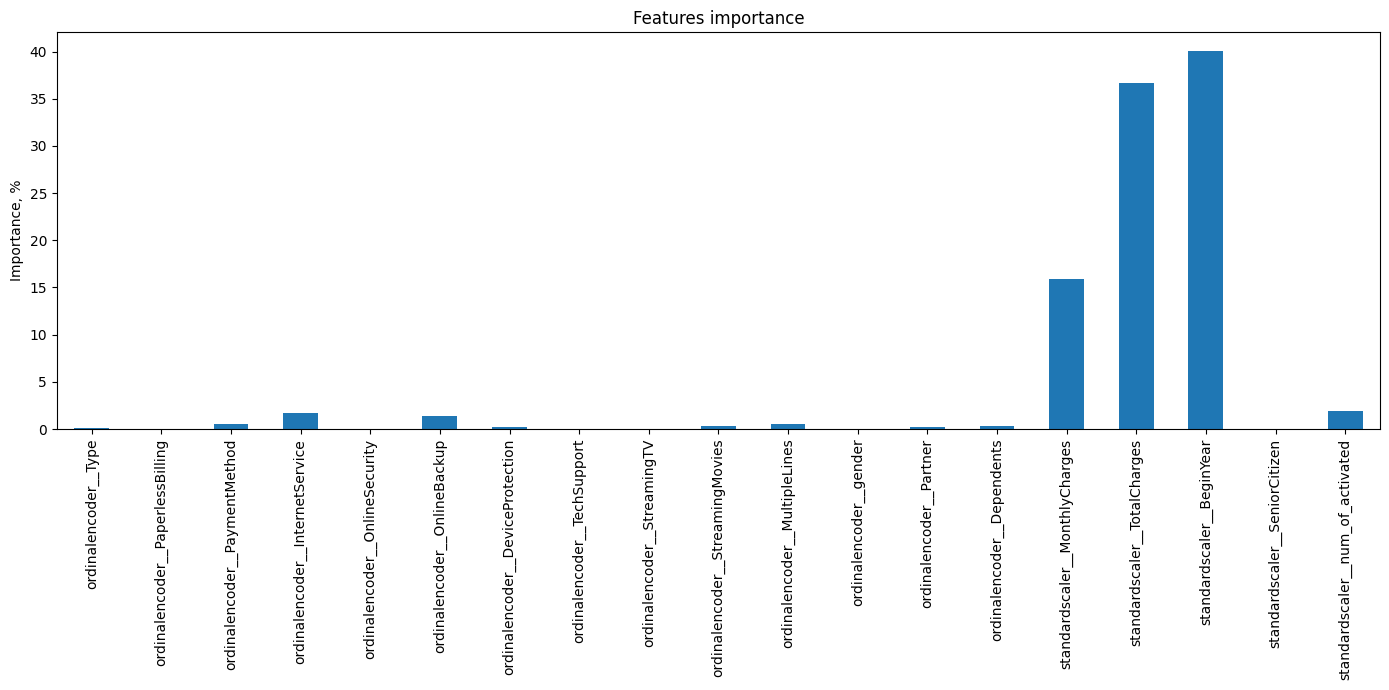

In [89]:
cat_imp = pd.Series(cb_model_final.get_feature_importance(),
                         x_year_train_oe.columns)
fig, ax = plt.subplots(figsize=(14,7))
cat_imp.plot.bar(ax=ax)
ax.set_title('Features importance')
ax.set_ylabel('Importance, %')
fig.tight_layout()

Очевидное невероятное: существенно важны всего несколько признаков!
- общие расходы важнее ежемесячных в полтора раза, но оба признака очень важны. Корреляция между ними есть, но всё же не очень большая - порядка 0.7. Это значит, что можно оставить оба признака
- год подписания договора очень важен! Второй по важности признак после общих расходов
- признак количества дополнительных подключенных услуг существенно важнее категориальных столбцов с фактом подключения  - значит, их можно попробовать удалить
- категориальный признак типа подключения интернета тоже важен
- признак года подключения важен
- факт выставления чека на электронную почту не важен, можно удалять
- важность типа подключения и метода оплаты соизмеримо не очень большая
- важность пола минимальна, что подверждает гипотезу из исследовательского анализа данных - в целом заивисимости целевого признака от пола. Признак можно удалить. Аналогичная важность - у признака наличия партнёра
- наличие иждивенцев влияет на целевой признак, хоть и совсем немного
- признак наличия пенсионного статуса не важен (на уровне десятых долей процента) - можно удалять этот признак
- признак количества подключенных услуг критично важен!

Итого: пробуем построить модель CatBoostRegressor на датасете со следующими признаками: общие и ежемесячные расходы, год подписания контракта, количество подключенных услуг, тип оплаты и подключения интернета, тип оплаты и наличие иждивенцев.

#### Построение модели на сокращённом наборе признаков

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> хорошо, плюс за доп исследование

In [90]:
x_train_shot = x_year_train[['Type', 'PaymentMethod', 'InternetService', 'Dependents',
                        'Partner', 'MonthlyCharges', 'TotalCharges', 'BeginYear', 'num_of_activated']]
#                        'MonthlyCharges', 'TotalCharges', 'BeginYear', 'num_of_activated']]

Сократили количество колонок в два раза, что позволило высвободить больше половины используемой памяти, занимаемой обучающим датасетом.

Засчёт того, что в трансформере выбор колонок реализован с использованием ColumnSelector по типу данных - новый трансформер писать не надо - а значит, можно пользоваться тем же пайплайном.

Теперь запускаем пайплайн с CatBoost классификатором - снова с подбором гиперпараметров, поскольку изменилось количество признаков

In [91]:
cb_shot_params = {'catboostclassifier__learning_rate': np.arange(.02, .04, .01),
            'catboostclassifier__depth': np.arange(4, 6, 2),
            'catboostclassifier__l2_leaf_reg': np.arange(7, 11, 2)}

cb_shot_best_score, cb_shot_best_params, cb_shot_best_time = model_pipeline(oe_transformer,
                               CatBoostClassifier(random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'),
                               x_train_shot, y_year_train,
                               params=cb_shot_params
                                )

Для модели <catboost.core.CatBoostClassifier object at 0x7e71fe301ba0> метрика ROC-AUC =0.947
время обучения =4.18, параметры модели:{'catboostclassifier__depth': 4, 'catboostclassifier__l2_leaf_reg': 9, 'catboostclassifier__learning_rate': 0.02}


В общем, можно было это не делать - метрика не изменилась с точностью до тысячных, а время обучения возросло.

### Вычисление метрик на тестовой выборке

Конфигурация модели определена окончательно - это CatBoost классификатор в связке с пользовательским преобразователем данных, обученный на наборе признаков с годом подписания договора без длительности. Теперь можно вычислить итоговое значение целевой метрики такой модели на тестовой выборке, а также посчитать дополнительные метрики и построить ROC-кривую.

In [92]:
x_year_test_oe = pd.DataFrame(oe_transformer.transform(x_year_test),
                           columns=oe_transformer.get_feature_names_out())

In [93]:
cb_predict = cb_model_final.predict(x_year_test_oe)

In [94]:
probabilities_one_valid = cb_model_final.predict_proba(x_year_test_oe)[:, 1]
roc_auc_ran_model = roc_auc_score(y_year_test, probabilities_one_valid)
print(f'Метрика ROC-AUC для классификатора на тестовой выборке ={roc_auc_ran_model:.3}')

Метрика ROC-AUC для классификатора на тестовой выборке =0.958


Дополнительно посчитаем метрику f1:

In [95]:
f1_ran_model = f1_score(y_year_test, cb_predict)
print(f'Метрика f1 для классификатора на тестовой выборке ={f1_ran_model:.3}')

Метрика f1 для классификатора на тестовой выборке =0.791


Такое значение означает, что модель хорошо прогнозирует класс 1, то есть что клиент собирается уйти.

В качестве завершающего штриха построим ROC-кривую:

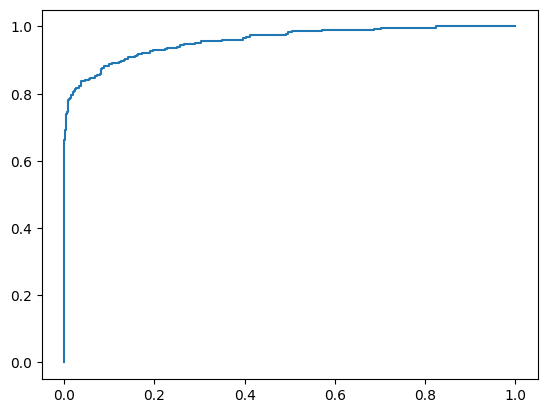

In [96]:
y_pred_proba = cb_model_final.predict_proba(x_year_test_oe)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_year_test, y_pred_proba)

#create ROC curve
plt.plot (fpr,tpr)

Видно, что изгиб кривой высок - значит, модель хорошо классифицирует клиентов по категориям.

Отдельно выведем матрицу ошибок и обратим внимание на количество ложноотрицательных прогнозов: то есть случаев, когда модель не спрогнозировала уход клиента. Смотрим на эту характеристику отдельно, так как предложить промокод лояльному клиенту (потенциально недополученная прибыль) - это не так критично, как не удержать клиента, планирующего прервать сотрудничество.

Выводим матрицу ошибок, сразу концертируем количество предсказаний в процент от общего числа предсказаний:

In [97]:
print(confusion_matrix(y_year_test, cb_predict) / len(y_year_test) * 100)

[[79.27314026  4.6564452 ]
 [ 2.49858035 13.57183419]]


Ложноотрицательная ошибка будет совершена моделью с вероятностью всего в 2,5 процента! То есть потенциально уходящего клиента модель пропустит с вероятнотью менее трёх процентов. С вероятностью в 4.6 процента рекомендательная система, основанная на этой модели, предложит промокод лояльному клиенту, который и не собирался никуда уходить.

## Заключение

Данный проект посвящён решению задачи классификации и прогнозированию оттока клиентов оператора связи "Ниединогоразрыва.com". Если модель определяет клиента как собирающегося уйти - планируется предложение клиенту скидочных промокодов и выгодных предложений. Входные данные представляют собой четыре датасета с информацией о клиенте и услугах, которыми он пользуется. Для оценки качества модели будет использована метрика ROC-AUC, в качестве дополнительной - метрика f1. Также при выборе модели будет учитываться время обучения.

Первая часть работы посвящена чтению и обзору данных. Выполнена загрузка данных и предворительный обзор каждого файла. Датасеты с информацией о клиентах и заключенных договорах содержат семь тысяч строк - по количеству клиентов, датасеты по услугам телефонии и интернета - 6 и 5,5 тысяч строк соответственно. Разница обусловлена количеством пользователей, пользующихся соответствующим сектором услуг. Явных пропусков в данных нет. Выполнен предварительный обзор каждого датасета: изучены распределения, выбросы, особенности.
Все признаки в этом датасете - качественные. Что касается особенностей личной информации, типичный абонент оператора - младше пенсионного возраста, имеющий иждивенцев, без явной выраженности в сторону какого-то пола и семейного положения. Преимущественно они предпочитают помесячный платёж, размер которого зависит от сегмента пользователя. Большинство пользователей составляют эконом-сегмент и платят около 20 долларов в месяц. Скорее всего, эта сумма соответствует ежемесячному платежу бюджетного тарифного плана. Однако, есть и клиенты премиум-сегмента - пик распределения их расходов находится в районе 80-100 долларов в месяц. Любопытным представляется распределение по году подписания договора  - есть явный пик в районе 2019-ого года. Подробному изучению причинно-следственных связей посвящён следующий раздел. Проведено преобразование типов данных в столбце с общими расходами из строки в численный формат. Неявные пропуски заполнены нулевыми значениями, так как соответсвуют строкам с новыми клиентами, подписавшими договор в месяц выгрузки базы: данные об их первой платеже ещё отсутствовали в базе на  момент выгрузки.

С целью формирования единого датасета признаков таблицы объединены таким образом, чтобы включить в себя данные обо всех предоставленных клиентах. Появившиеся пропуски образовались в категориальных столбцах с услугами интернета и/или телефонии. Пропуски заполнены таким образом, чтобы соответсвовать факту отсутствия подключения услуги.

Добавлены новые синтетические признаки: год подписания договора и суммарное количество подключенных клиентом услуг. Явным образом выявлен целевой признак из стобца с датой окончания действия договора: если даты нет - клиент активен и продолжает пользоваться услугами оператора, в противном случае клиент потерян. Затем ненужные столбцы: с датами начала и окончания контракта - удалены.

Следующий раздел посвящён исследовательскому анализу данных. Изучены распределения всех признаков в разрезе значения целевого признака. Обнаружено, что клиенты эконом-сегмента значительно более лояльны клиентов премиум-сегмента. Люди с наличием партнёра уходить чуть более склонны, а вот налиие иждивенцев больше мотивирует на стабильность. Можно ожидать высокую важность признака с количеством подключенных услуг - распределения очень отличаются. Среди активных коиентов пик приходится на 2-3 подключенные услуги, а среди ушедших - на 5-6 подключенных услуг.  Также возможно имеет смысл разработать пакеты более выгодного комплексного подключения услуг - в каждой конкретной услуге нет явного дисбаланса в целевом признаке, однако уходящие клиенты в основном пользуются большим количеством допуслуг.

Проведена проверка на мультиколлинеарность. Видна взаимосвязь между ежемесячными и общими расходами, а также между расходами и типом подключения интернета. Те, кто подключают стриминговое телевидение, в основном подключают и каталог фильмов: видимо, это киноманы. Возможно, имеет смысл разработки выгодного пакетного предложения для этих услуг. Наличие партнёра связано не только с наличием иждивенцев, но и с суммарным количеством подключенных услуг. Дополнительно изучено распределение платежей и количества подключаемых услуг в разрезе года подписания договора. В качестве порогового значения выбран 2019ый год - год, когда заметен явный прирост клиентов. Видно, что в конце 2018ого-2019ого компания, вероятно, существенно поменяла стратегию и стала больше ориентироваться на привлечение бОльшего количества клиентов эконом-сегмента. Исходя из того, что клиенты с платежами в 80-100 долларов сохранились, а количество дополнительных услуг существенно сократилось - можно предположить, что компанией были пересмотрены тарифные планы и введено больше пакетных предложений. Ежемесячная прибыль от тех, кто пришёл в 2019ом году, больше почти в два раза - стратегия компании отлично сработала.

Следующий этап заключается в подготовке датасета для дальнейшего обучения моделей. Ранные разбиты на признаки и целевой признак, а затем - на обучающую и тестовую выборку в пропорциях 3:1 соответственно. Ввиду небольшого размера исходных данных валидационная выборка отдельно не выделяется, запланировано обучение моделей с использованием кросс-валидации. В датасете присутсвуют количественные признаки, котореы необходимо отмасштабировать, и качественные, которые нужно закодировать. Поскольку планируется обучение моделей различной конфигурации - линейные, случайный лес, бустинги - используется два варианта преобразования категориальных признаков - OneHotEncoder и OrdinalEncoder. В датасете присутствует существенный дисбаланс целевого признака: ушедшие клиенты составляют всего 15 процентов общего датасета. В качестве борьбы с дисбалансом выбран метод взвешивания классов внутренними методами конструктора модели.

Обучены следующие модели: логистическая регрессия, модель Ridge, SGD классификатор, LightGBM, модель случайного леса (отдельное дерево пробовать не будем), градиентный бустинг, CatBoost. Пайплайн включает в себя кросс-валидацию - это позволит в том числе обучать кодировщик на только на обучающей выборке на каждой итерации кросс-валидации. В рамках каждой модели - там, где это представляется возмодным - проведен подбор гиперпараметров с целью поиска экстремума целевой метрики. Классификатор CatBoost, показавший хорошее качество предсказания с заводскими настройками, обучен в двух конфигурациях - с использованием пользовательского кодировщика признаков и в варианте обучения модели на сырых данных с использованием внутренних кодировщиков модели. Продемонстрировано, что качество предсказания у таких моделей соизмеримо, однако скорость обучения модели на сырых данных ниже в три раза. На выходе для каждой модели получены значения метрики ROC-AUC на обучающей выборке и времени обучения лучшей конфигурации модели. Все значения продемонстрированы в сводной таблице. В качестве наиболее оптимальной выбрана модель CatBoostClassifier с использованием пользовательского кодировщика и подбором гиперпараметров - такая модель демонстрирует максимальное значение метрики при конкурентноспособном времени обучения.

Проведено тестирование полученной модели методом сравнения её с константной: предобученный классификатор предсказывает факт потенциального ухода клиента из компании существенно лучше наивного предиктора: целевая метрика классификатора практически в два раза выше.

Обучение каждой модели проведено в двух вариантах конфигураций - на датасете с признаком года подписания договора и с использованием в качестве признака длительность контракта. Использование обоих зарактеристик  одновременно невозможно, поскольку ведёт к утечке целевого признака.

Изучена важность признаков получившейся модели: как и прогнозировалось, агрегированный количественный признак количества подключенных услуг важнее категориальных признаков по каждой услуге. Важны признаки расходов, введение признака года подписания договора оправдало себя: это второй по важности признак. Проведено дополнительное обучение классификатора CatBoost на сокращённом количестве признаков. Метрика изменяется в тысячных долях, а время обучения немного увеличивается. Данный подход может быть использован при ограничении в памяти - сокращённый датасет занимает в три раза меньше места при сохранении качества предсказаний. Однако, в условиях текущего ТЗ выбрана стратегия обучения модели на полном наборе признаков.

Финальный этап - вычисление метрик обученной модели на тестовой выборке. Получившиеся результаты:
- ROC-AUC = 0.96
- f1-score = 0.89
- ROC-кривая демонстрирует, что модель хорошо справляется с разделением клиентов по категориям
- построена матрица ошибок: клиента, планирующего расторгнуть договор, модель пропустит с вероятностью в 2.5%.

Поскольку исходная цель состояла в прогнозировании клиентов, планирующих уйти, с целью предложения ему промокодов, выгодных предложений и тд - модель качественно решает поставленную задачу.






